<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230514.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [4]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [5]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

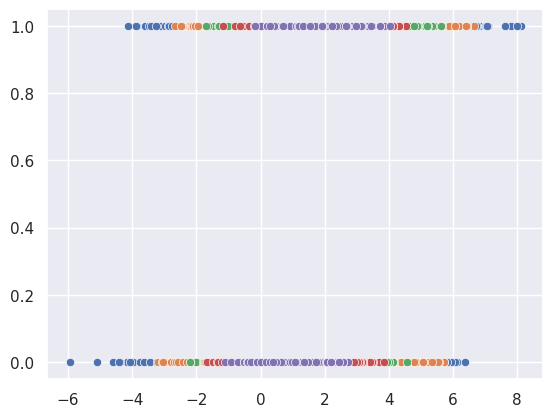

In [6]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

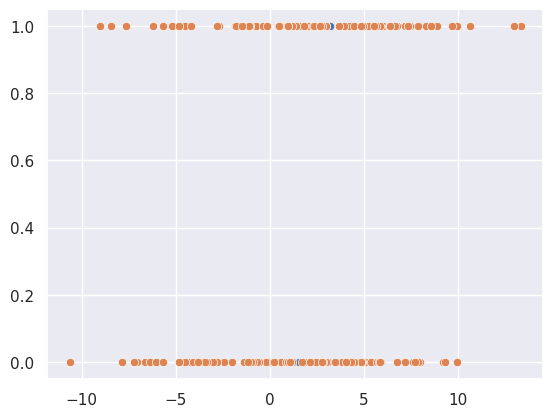

In [7]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [8]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [9]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


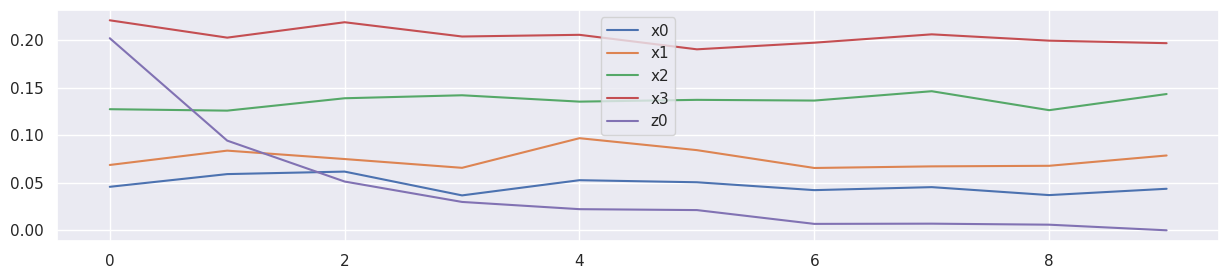

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 34.62it/s]


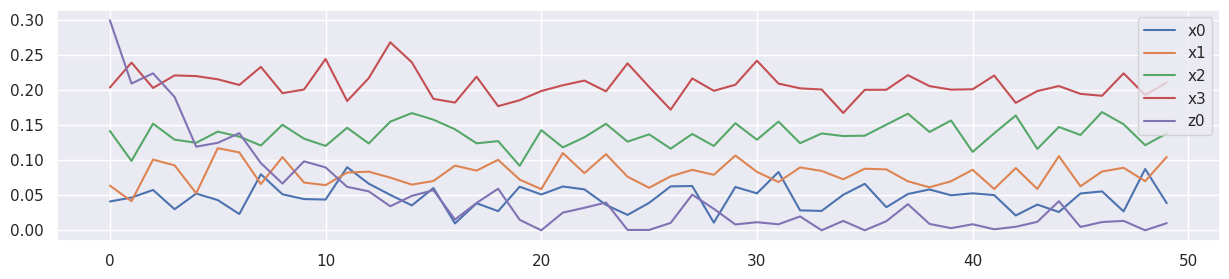

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 62.59it/s]


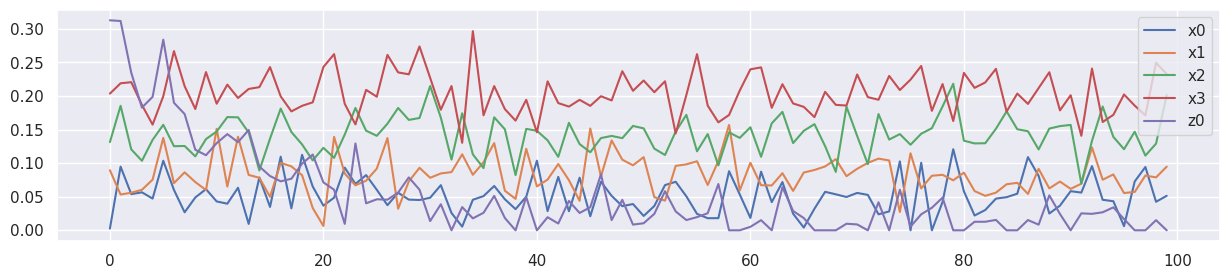

Bucket size 200


100%|██████████| 200/200 [00:01<00:00, 101.60it/s]


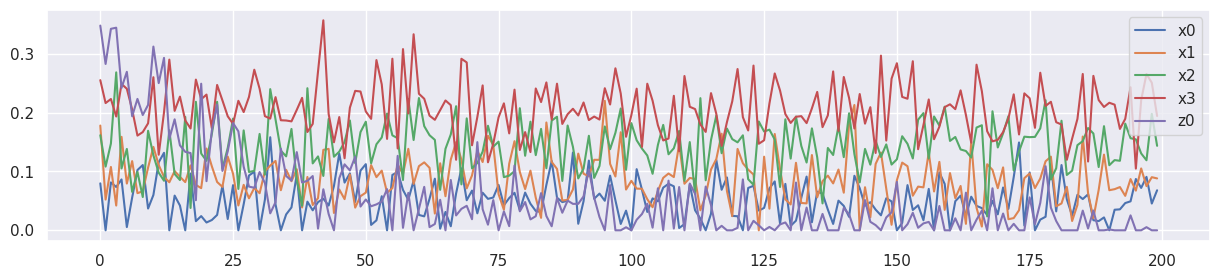

In [10]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 120.24it/s]


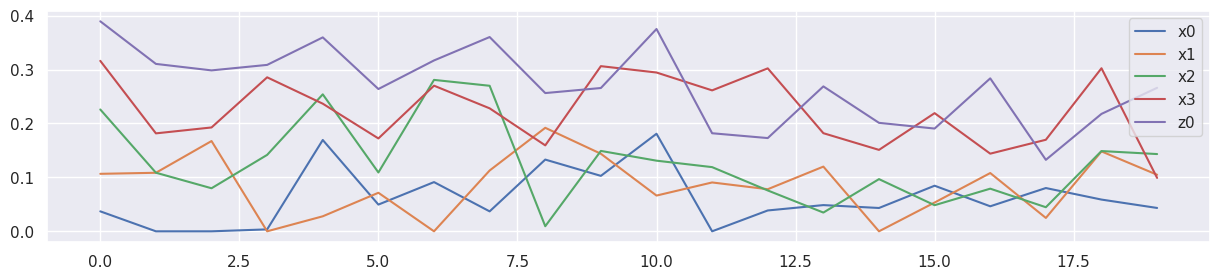

In [11]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 1000/1000 [00:17<00:00, 56.49it/s]


MSE: 0.26
RMSE: 0.51


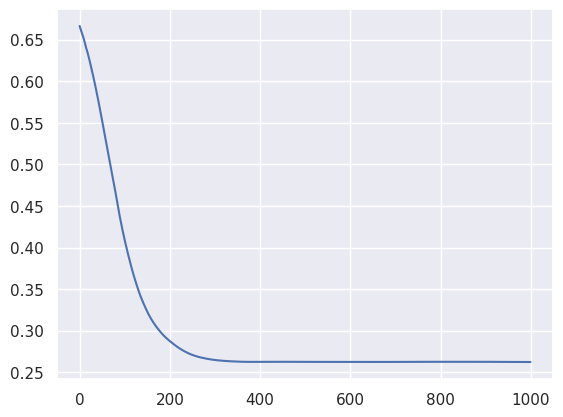

In [12]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

+ F1 측정

+ 비교 대상의 측정치

In [13]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

In [14]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8685714285714285


+ 2000~40000까지의 R-squared score 측정 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 189/189 [00:00<00:00, 604.00it/s]


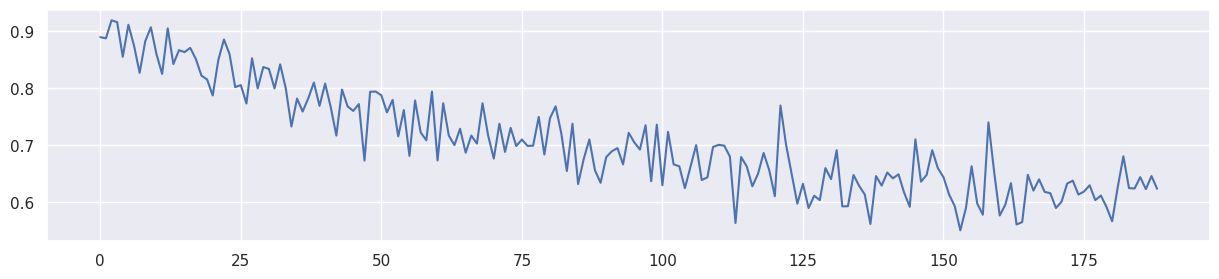

{'lambda': ['Feature 5'], 'test_f1': [0.8685714285714285], 'init_f1': [0.8899082568807338], 'mean_f1': [0.7058765598487894], 'last_f1': [0.6238532110091742], 'MI(y^,z)': [0.2622620324764773]}


In [15]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(pd.DataFrame(X_test[:,4],columns=['z0']), predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)


## feature 5개 + bucket(B) = feature 6개를 학습

In [16]:
# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

100%|██████████| 1000/1000 [00:18<00:00, 55.15it/s]


MSE: 0.30
RMSE: 0.54


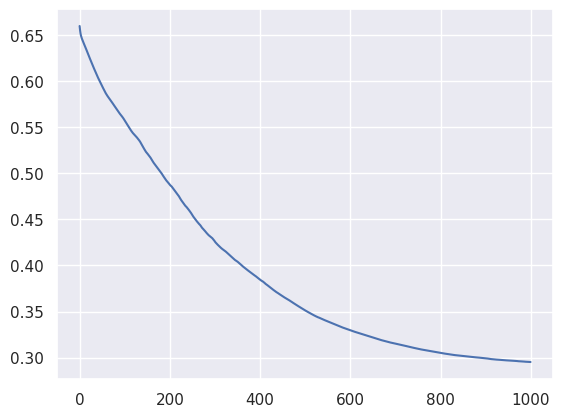

In [17]:
seed_everything()

X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(6, 24),
    nn.ReLU(),
    nn.Linear(24, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [18]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.875


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 189/189 [00:00<00:00, 601.48it/s]


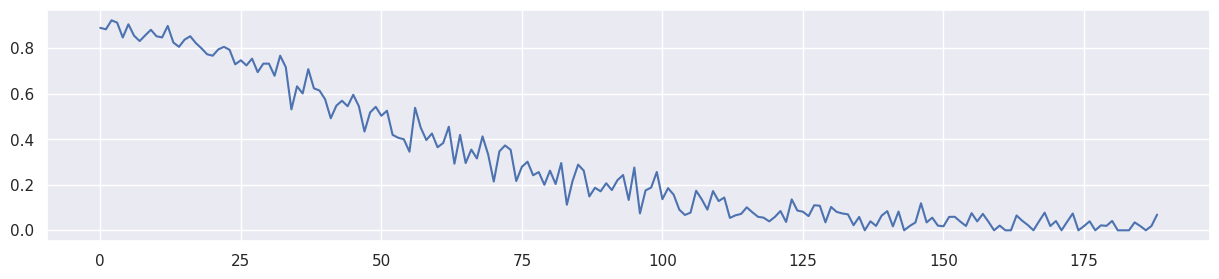

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467

In [19]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(pd.DataFrame(X_test[:,4],columns=['z0']), predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3','z0','b']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 6')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

## z0를 빼고, 4개 feature로 학습

100%|██████████| 1000/1000 [00:17<00:00, 57.29it/s]


MSE: 0.13
RMSE: 0.36


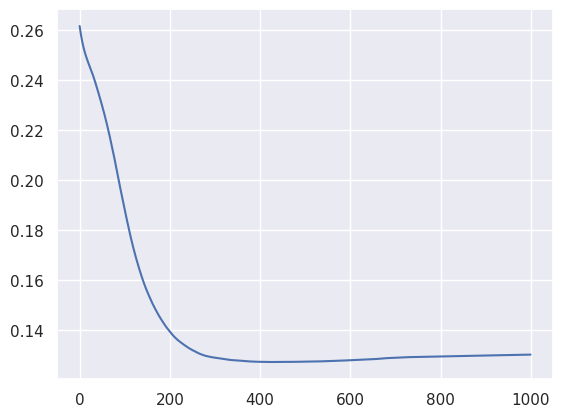

In [20]:
seed_everything()

X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100 # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [21]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.7657142857142858


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 189/189 [00:00<00:00, 632.84it/s]


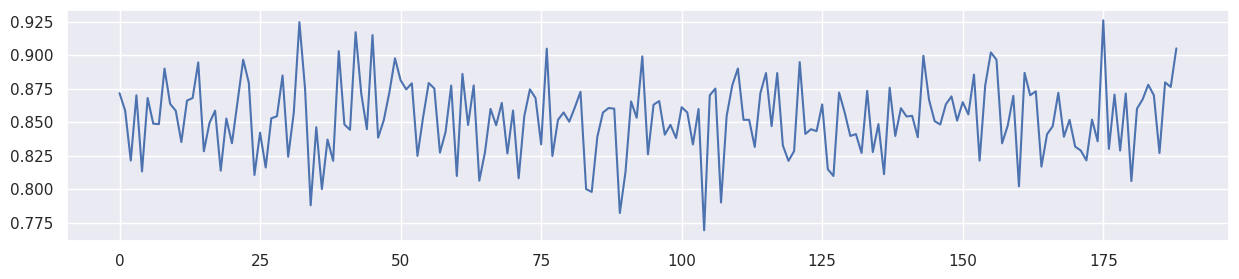

lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596

In [22]:
predicted_y = model(X_test)
predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
f1 = f1_score(y_test, predicted_y)

mi_scores = make_mi_scores(X[1800:2000][['z0']], predicted_y, discrete_features="auto")

XT = X[2000:][['x0','x1','x2','x3']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

pd.DataFrame(result_table3)

+ 위에서 보면.... 학습과정에서, 현재는 학습에 효과가 있지만 향후 잠재적으로 성능을 저해할 수 있는 feature를 탐지하여 이의 효과를 경감 또는 (보정) 할 수 있는 학습 방법을 찾아야 하는 것!!!

## RF-Train의 적용

+ 위의 데이터에서, sensitive attribute는 z0에 대당된다.
+ 따라서, MI(y^|z0) = 0 이되어야 하고,
+ Fairness discriminator에서는  Y^과 z0의 loss가 커야 한다! 즉, 최대한 상관 없어야 한다.
+ OK, 일단 이렇게 구성해 본다!

In [23]:
!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 1.45 MiB/s, done.


In [24]:
%cd fr-train
!pwd

/content/fr-train
/content/fr-train


In [25]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

+ Generator의 구현 = 위에서 feature 5개의 model과 동일
+ DiscriminatorF = Y^과 z0가 같아지지 않게 학습 ??

In [26]:

def test_model(model_, tX, ty, s1):
    """Tests the performance of a model.

    Args:
        model_: A model to test.
        X: Input features of test data.
        y: True label (1-D) of test data.
        s1: Sensitive attribute (1-D) of test data.

    Returns:
        The test accuracy and disparate impact of the model.
    """
    
    model_.eval()
    
    y_hat = model_(tX)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [27]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1),
            nn.Sigmoid()            
        )

    def forward(self, x1, x2):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(torch.cat((x1, x2), 1))
        return predicted_z
    

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF2(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF2, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 4),
            nn.Linear(4, 1)       
        )

    def forward(self, x1):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(x1)
        return predicted_z
    

In [28]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    #mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_loss.backward()
        g_losses.append(g_loss)
        optimizer_G.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1, mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1, mi, generator

In [29]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.Adam(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    real_label = 1
    fake_label = 0

    rlabel = torch.full((train_len,), real_label, dtype=torch.float32).reshape(-1,1)
    flabel = torch.full((train_len,), fake_label, dtype=torch.float32).reshape(-1,1)
    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # y과 z는 무관 (MI=0) 이면, True
        # y^과 z가 상관 (MI>0) 이면, False 로 정의 한다. 
        #r_loss = bce_loss(discriminator_F(y_train.reshape(-1,1), s1_train.reshape(-1,1)),rlabel)
        #f_loss = bce_loss(discriminator_F(gen_y, s1_train.reshape(-1,1)),flabel)

        r_loss = bce_loss(discriminator_F(y_train.reshape(-1,1), s1_train.reshape(-1,1)),rlabel)
        f_loss = bce_loss(discriminator_F(gen_y, s1_train.reshape(-1,1)),flabel)

        d_f_loss =  (r_loss + f_loss) 
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()        
        
        #loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        # -------------------
        #  Update Generator
        # -------------------
        g_cost = bce_loss(gen_y, y_train.reshape(-1,1))
        #f_cost = bce_loss(discriminator_F(gen_y.detach(), s1_train.reshape(-1,1)),rlabel)
        g_loss = (1-lambda_f)*g_cost + lambda_f*d_f_loss
        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()    

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [30]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model22(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF2()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.Adam(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    real_label = 1
    fake_label = 0

    rlabel = torch.full((train_len,), real_label, dtype=torch.float32).reshape(-1,1)
    flabel = torch.full((train_len,), fake_label, dtype=torch.float32).reshape(-1,1)
    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # y과 z는 무관 (MI=0) 이면, True
        # y^과 z가 상관 (MI>0) 이면, False 로 정의 한다. 

        # y와 z는 상관관계가 있으므로... r_loss는 최소화 시키고...
        r_loss = mse_loss(discriminator_F(y_train.reshape(-1,1)), s1_train.reshape(-1,1))
        # y^와 z는 최대한 무관하게... f_loss 최대화 시킨다..
        f_loss = mse_loss(discriminator_F(gen_y), s1_train.reshape(-1,1)) * 0.3

        d_f_loss =  (r_loss - f_loss) 
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()        
        
        #loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        # -------------------
        #  Update Generator
        # -------------------
        g_cost = bce_loss(gen_y, y_train.reshape(-1,1))
        #f_cost = bce_loss(discriminator_F(gen_y.detach(), s1_train.reshape(-1,1)),rlabel)
        g_loss = (1-lambda_f)*g_cost + lambda_f*d_f_loss
        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()    

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [31]:
def test_all_data(generator):

    XT = X[2000:][['x0','x1','x2','x3','z0']]
    yT = y[2000:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            predicted_y = generator(tmp_x)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 189/189 [00:00<00:00, 626.35it/s]


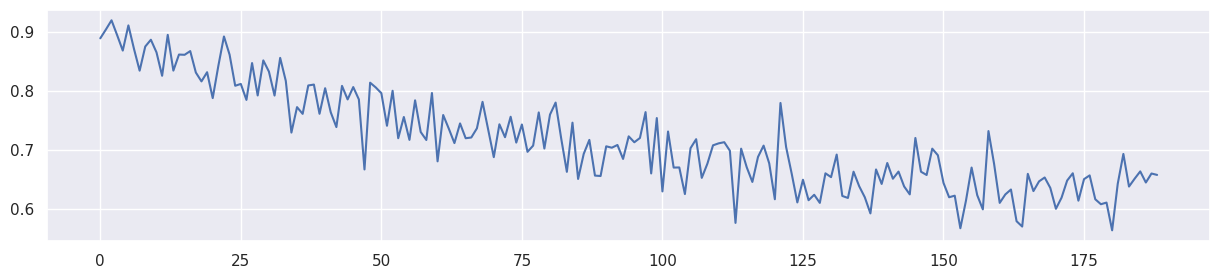

Mean F1 for all data: 0.7169960936024915
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.764362]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 1.385715] [G loss: 0.748424]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 1.379816] [G loss: 0.721642]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 1.369719] [G loss: 0.692447]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 1.361597] [G loss: 0.661667]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 1.359293] [G loss: 0.629466]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 1.361001] [G loss: 0.596741]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 1.364285] [G loss: 0.563744]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 1.368029] [G loss: 0.531376]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 1.371693] [G loss: 0.499893]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 1.375391] [G loss: 0.471104]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 1.378541] [G loss: 0.446025]
[Lambda: 0.100000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 602.21it/s]


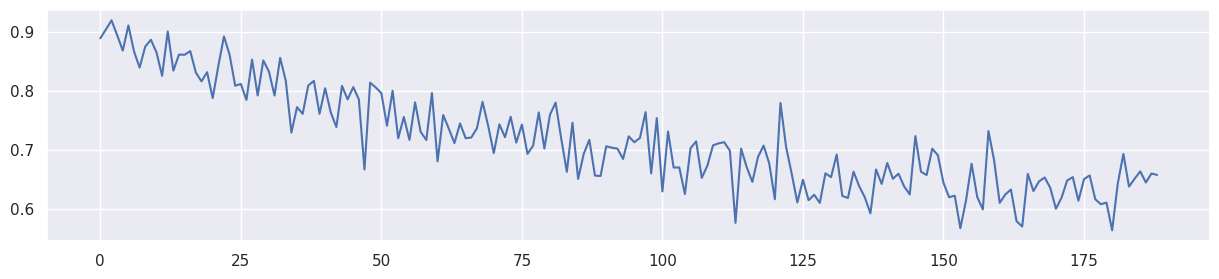

Mean F1 for all data: 0.7170752811002495
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.833470]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 1.385707] [G loss: 0.819187]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 1.379258] [G loss: 0.794397]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 1.366871] [G loss: 0.767057]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 1.356212] [G loss: 0.738834]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 1.352615] [G loss: 0.710249]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 1.354324] [G loss: 0.681624]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 1.358529] [G loss: 0.652855]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 1.363284] [G loss: 0.624683]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 1.367940] [G loss: 0.597247]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 1.372619] [G loss: 0.572237]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 1.376532] [G loss: 0.550378]
[Lambda: 0.200000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 621.81it/s]


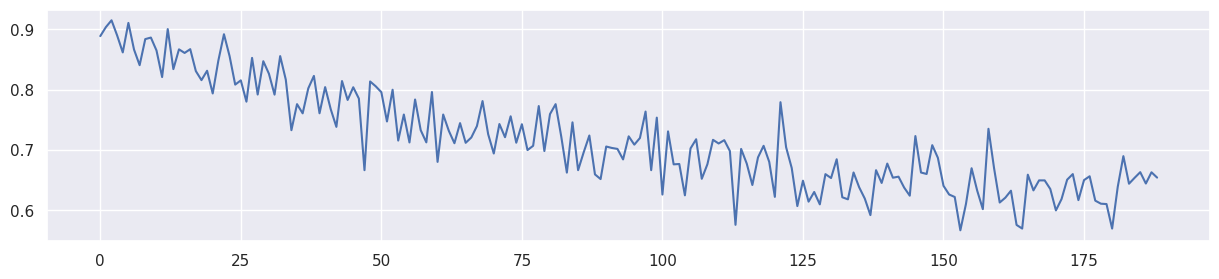

Mean F1 for all data: 0.7176960107442528
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.902577]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 1.385694] [G loss: 0.889952]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 1.378446] [G loss: 0.867016]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 1.362389] [G loss: 0.841007]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 1.346843] [G loss: 0.814998]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 1.340973] [G loss: 0.789855]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 1.342740] [G loss: 0.765414]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 1.347964] [G loss: 0.741051]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 1.354569] [G loss: 0.717223]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 1.361214] [G loss: 0.694206]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 1.367934] [G loss: 0.672915]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 1.373049] [G loss: 0.654381]
[Lambda: 0.300000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 594.01it/s]


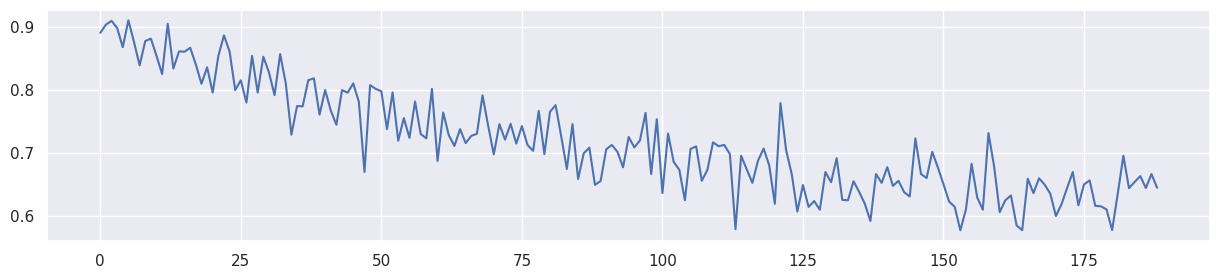

Mean F1 for all data: 0.7185592664472374
[Lambda: 0.400000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 0.971684]
[Lambda: 0.400000] [Epoch 200/4000] [D_F loss: 1.385651] [G loss: 0.960716]
[Lambda: 0.400000] [Epoch 400/4000] [D_F loss: 1.377058] [G loss: 0.939390]
[Lambda: 0.400000] [Epoch 600/4000] [D_F loss: 1.354234] [G loss: 0.913654]
[Lambda: 0.400000] [Epoch 800/4000] [D_F loss: 1.329525] [G loss: 0.888927]
[Lambda: 0.400000] [Epoch 1000/4000] [D_F loss: 1.318446] [G loss: 0.867105]
[Lambda: 0.400000] [Epoch 1200/4000] [D_F loss: 1.319638] [G loss: 0.847040]
[Lambda: 0.400000] [Epoch 1400/4000] [D_F loss: 1.326620] [G loss: 0.827323]
[Lambda: 0.400000] [Epoch 1600/4000] [D_F loss: 1.335311] [G loss: 0.808170]
[Lambda: 0.400000] [Epoch 1800/4000] [D_F loss: 1.345255] [G loss: 0.790189]
[Lambda: 0.400000] [Epoch 2000/4000] [D_F loss: 1.355975] [G loss: 0.773466]
[Lambda: 0.400000] [Epoch 2200/4000] [D_F loss: 1.364482] [G loss: 0.758701]
[Lambda: 0.400000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 630.80it/s]


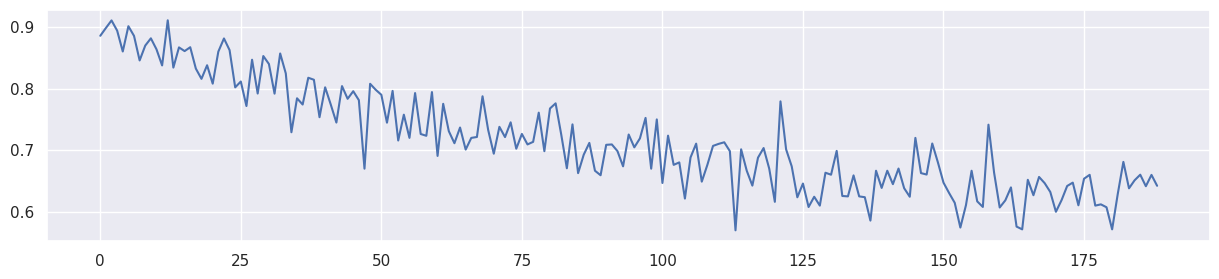

Mean F1 for all data: 0.716829862616852
[Lambda: 0.500000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.040792]
[Lambda: 0.500000] [Epoch 200/4000] [D_F loss: 1.385086] [G loss: 1.031416]
[Lambda: 0.500000] [Epoch 400/4000] [D_F loss: 1.365266] [G loss: 1.010256]
[Lambda: 0.500000] [Epoch 600/4000] [D_F loss: 1.314786] [G loss: 0.982919]
[Lambda: 0.500000] [Epoch 800/4000] [D_F loss: 1.272525] [G loss: 0.960884]
[Lambda: 0.500000] [Epoch 1000/4000] [D_F loss: 1.258224] [G loss: 0.943746]
[Lambda: 0.500000] [Epoch 1200/4000] [D_F loss: 1.258621] [G loss: 0.928428]
[Lambda: 0.500000] [Epoch 1400/4000] [D_F loss: 1.265445] [G loss: 0.913316]
[Lambda: 0.500000] [Epoch 1600/4000] [D_F loss: 1.274780] [G loss: 0.899293]
[Lambda: 0.500000] [Epoch 1800/4000] [D_F loss: 1.288391] [G loss: 0.886958]
[Lambda: 0.500000] [Epoch 2000/4000] [D_F loss: 1.305207] [G loss: 0.875826]
[Lambda: 0.500000] [Epoch 2200/4000] [D_F loss: 1.322714] [G loss: 0.865882]
[Lambda: 0.500000] [Epoch 2400/4000] [D_F l

100%|██████████| 189/189 [00:00<00:00, 608.11it/s]


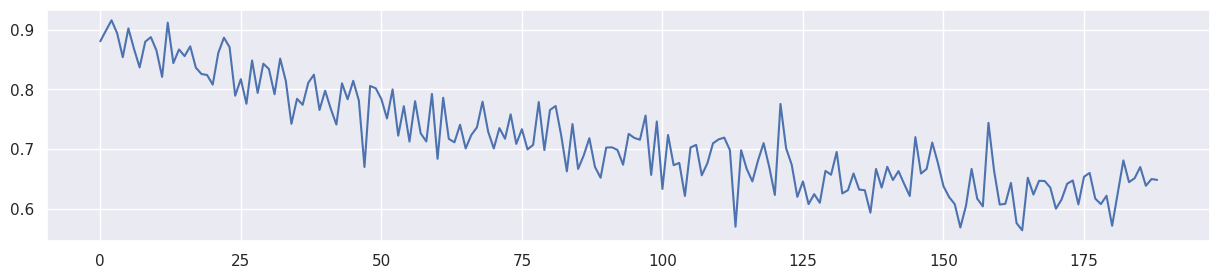

Mean F1 for all data: 0.7167127527365508
[Lambda: 0.600000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.109899]
[Lambda: 0.600000] [Epoch 200/4000] [D_F loss: 1.384624] [G loss: 1.101906]
[Lambda: 0.600000] [Epoch 400/4000] [D_F loss: 1.359386] [G loss: 1.078351]
[Lambda: 0.600000] [Epoch 600/4000] [D_F loss: 1.286432] [G loss: 1.040596]
[Lambda: 0.600000] [Epoch 800/4000] [D_F loss: 1.209703] [G loss: 1.013609]
[Lambda: 0.600000] [Epoch 1000/4000] [D_F loss: 1.178470] [G loss: 1.000641]
[Lambda: 0.600000] [Epoch 1200/4000] [D_F loss: 1.171644] [G loss: 0.989958]
[Lambda: 0.600000] [Epoch 1400/4000] [D_F loss: 1.170898] [G loss: 0.979577]
[Lambda: 0.600000] [Epoch 1600/4000] [D_F loss: 1.171883] [G loss: 0.970392]
[Lambda: 0.600000] [Epoch 1800/4000] [D_F loss: 1.174362] [G loss: 0.963220]
[Lambda: 0.600000] [Epoch 2000/4000] [D_F loss: 1.180557] [G loss: 0.957649]
[Lambda: 0.600000] [Epoch 2200/4000] [D_F loss: 1.187429] [G loss: 0.953300]
[Lambda: 0.600000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 611.30it/s]


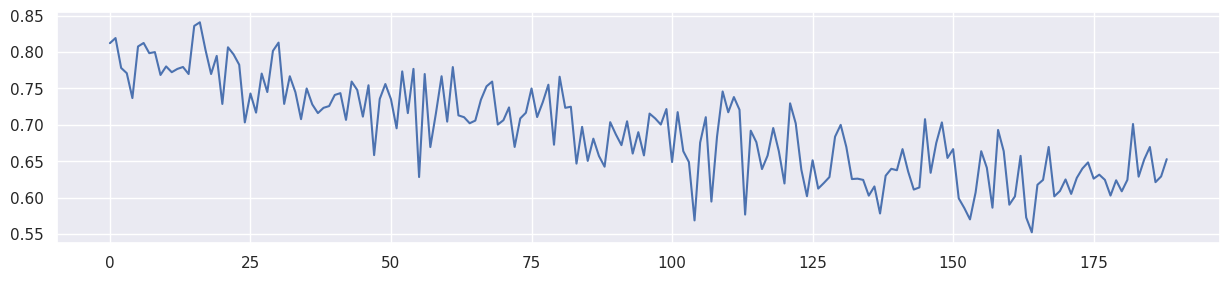

Mean F1 for all data: 0.6920815777961908
[Lambda: 0.700000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.179006]
[Lambda: 0.700000] [Epoch 200/4000] [D_F loss: 1.384364] [G loss: 1.172318]
[Lambda: 0.700000] [Epoch 400/4000] [D_F loss: 1.352243] [G loss: 1.144222]
[Lambda: 0.700000] [Epoch 600/4000] [D_F loss: 1.258360] [G loss: 1.089529]
[Lambda: 0.700000] [Epoch 800/4000] [D_F loss: 1.159981] [G loss: 1.048331]
[Lambda: 0.700000] [Epoch 1000/4000] [D_F loss: 1.106517] [G loss: 1.033059]
[Lambda: 0.700000] [Epoch 1200/4000] [D_F loss: 1.087656] [G loss: 1.025751]
[Lambda: 0.700000] [Epoch 1400/4000] [D_F loss: 1.081852] [G loss: 1.018620]
[Lambda: 0.700000] [Epoch 1600/4000] [D_F loss: 1.079079] [G loss: 1.012759]
[Lambda: 0.700000] [Epoch 1800/4000] [D_F loss: 1.078945] [G loss: 1.008387]
[Lambda: 0.700000] [Epoch 2000/4000] [D_F loss: 1.079956] [G loss: 1.005195]
[Lambda: 0.700000] [Epoch 2200/4000] [D_F loss: 1.082166] [G loss: 1.002947]
[Lambda: 0.700000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 607.44it/s]


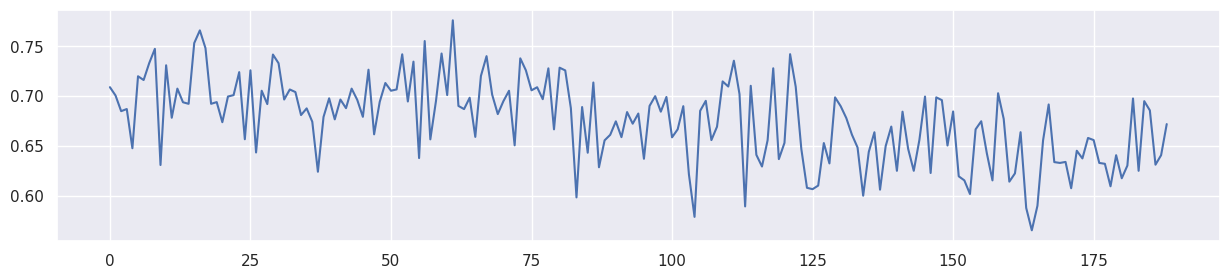

Mean F1 for all data: 0.6753588356134587
[Lambda: 0.800000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.248114]
[Lambda: 0.800000] [Epoch 200/4000] [D_F loss: 1.383965] [G loss: 1.242565]
[Lambda: 0.800000] [Epoch 400/4000] [D_F loss: 1.342603] [G loss: 1.206555]
[Lambda: 0.800000] [Epoch 600/4000] [D_F loss: 1.228619] [G loss: 1.127630]
[Lambda: 0.800000] [Epoch 800/4000] [D_F loss: 1.110432] [G loss: 1.062805]
[Lambda: 0.800000] [Epoch 1000/4000] [D_F loss: 1.041893] [G loss: 1.037911]
[Lambda: 0.800000] [Epoch 1200/4000] [D_F loss: 1.013065] [G loss: 1.031554]
[Lambda: 0.800000] [Epoch 1400/4000] [D_F loss: 1.004443] [G loss: 1.028972]
[Lambda: 0.800000] [Epoch 1600/4000] [D_F loss: 1.003139] [G loss: 1.026490]
[Lambda: 0.800000] [Epoch 1800/4000] [D_F loss: 1.004280] [G loss: 1.024115]
[Lambda: 0.800000] [Epoch 2000/4000] [D_F loss: 1.005393] [G loss: 1.021932]
[Lambda: 0.800000] [Epoch 2200/4000] [D_F loss: 1.006181] [G loss: 1.019991]
[Lambda: 0.800000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 627.32it/s]


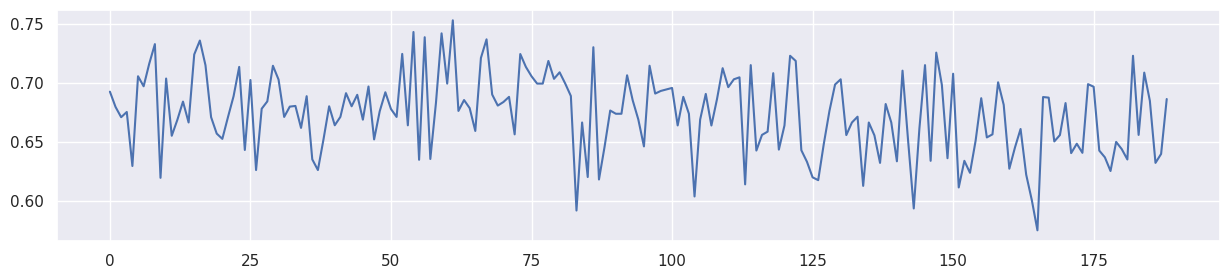

Mean F1 for all data: 0.6738530529835562
[Lambda: 0.900000] [Epoch 0/4000] [D_F loss: 1.386328] [G loss: 1.317221]
[Lambda: 0.900000] [Epoch 200/4000] [D_F loss: 1.383212] [G loss: 1.312479]
[Lambda: 0.900000] [Epoch 400/4000] [D_F loss: 1.329523] [G loss: 1.263401]
[Lambda: 0.900000] [Epoch 600/4000] [D_F loss: 1.193672] [G loss: 1.150553]
[Lambda: 0.900000] [Epoch 800/4000] [D_F loss: 1.067594] [G loss: 1.057277]
[Lambda: 0.900000] [Epoch 1000/4000] [D_F loss: 0.996381] [G loss: 1.015475]
[Lambda: 0.900000] [Epoch 1200/4000] [D_F loss: 0.963313] [G loss: 1.003051]
[Lambda: 0.900000] [Epoch 1400/4000] [D_F loss: 0.951129] [G loss: 1.000448]
[Lambda: 0.900000] [Epoch 1600/4000] [D_F loss: 0.947176] [G loss: 0.999522]
[Lambda: 0.900000] [Epoch 1800/4000] [D_F loss: 0.946042] [G loss: 0.998793]
[Lambda: 0.900000] [Epoch 2000/4000] [D_F loss: 0.945847] [G loss: 0.998031]
[Lambda: 0.900000] [Epoch 2200/4000] [D_F loss: 0.945854] [G loss: 0.997296]
[Lambda: 0.900000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 622.12it/s]


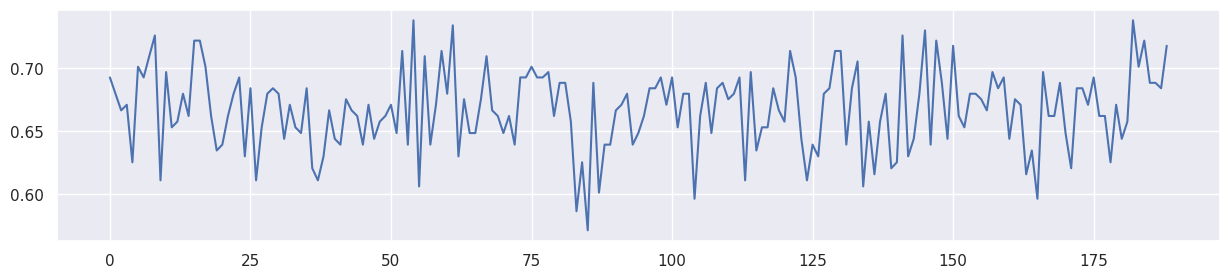

Mean F1 for all data: 0.6673744009113316


lambda   test_f1   init_f1   mean_f1   last_f1      MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  2.622620e-01
1  Feature 6  0.875000  0.889908  0.299367  0.068966  2.304670e-01
2  Feature 4  0.765714  0.871560  0.853043  0.904977  7.959555e-02
0        0.0  0.875000  0.888889  0.716996  0.657407  2.616669e-01
1        0.1  0.875000  0.888889  0.717075  0.657407  2.616669e-01
2        0.2  0.881356  0.888889  0.717696  0.654378  2.598196e-01
3        0.3  0.868571  0.890909  0.718559  0.644860  2.455515e-01
4        0.4  0.865169  0.885845  0.716830  0.642202  2.771431e-01
5        0.5  0.876404  0.880734  0.716713  0.648402  2.707110e-01
6        0.6  0.744589  0.812261  0.692082  0.652893  2.988178e-01
7        0.7  0.614286  0.709030  0.675359  0.671937  7.143892e-02
8        0.8  0.601399  0.692810  0.673853  0.686567  8.881784e-16
9        0.9  0.601399  0.692810  0.667374  0.717949  8.881784e-16

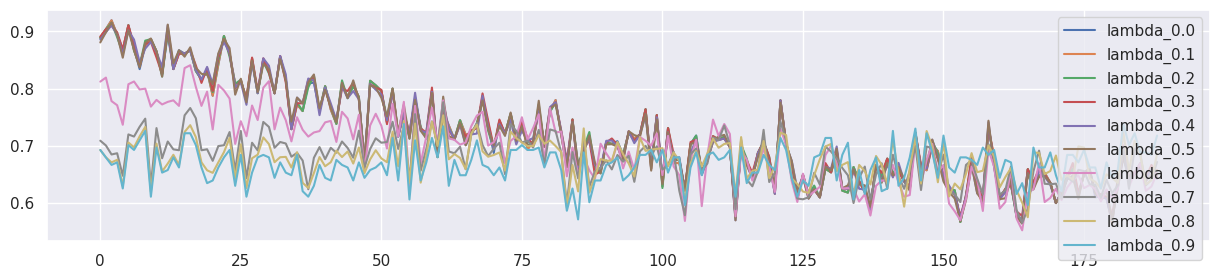

In [32]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)

result3_df = pd.DataFrame(result_table3)


pd.concat([result3_df, result2_df])


[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 189/189 [00:00<00:00, 635.19it/s]


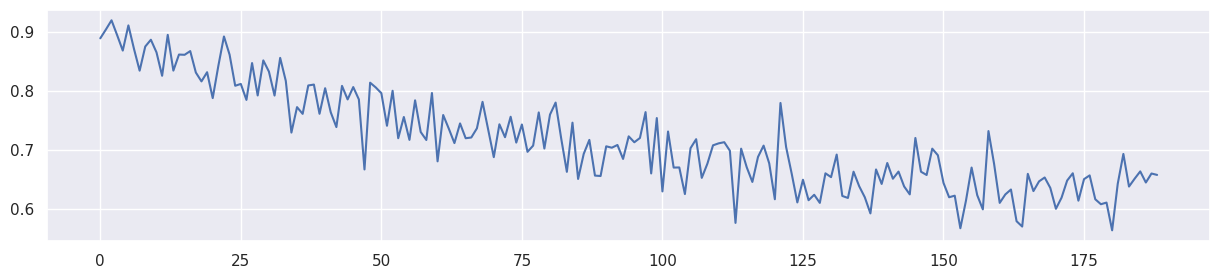

Mean F1 for all data: 0.7169960936024915
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 0.832770]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 0.833585] [G loss: 0.693393]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 0.213729] [G loss: 0.605726]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 0.195657] [G loss: 0.575629]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 0.201150] [G loss: 0.545888]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 0.207711] [G loss: 0.514309]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 0.215046] [G loss: 0.481998]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 0.222711] [G loss: 0.449594]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 0.230764] [G loss: 0.417634]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 0.238594] [G loss: 0.386566]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 0.245515] [G loss: 0.357750]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 0.251275] [G loss: 0.332951]
[Lambda: 0.100000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 626.63it/s]


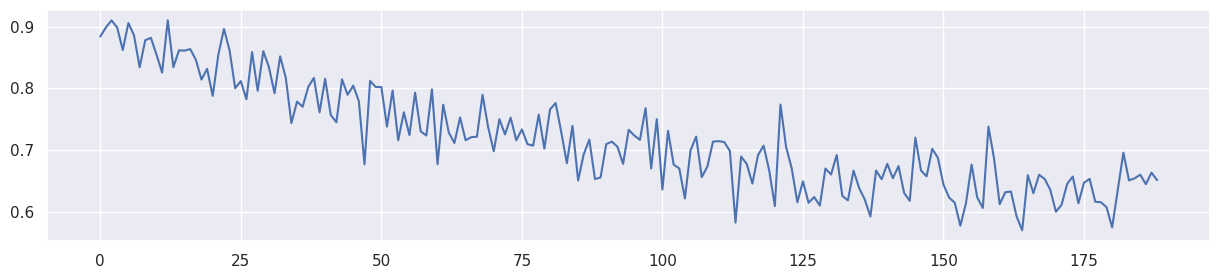

Mean F1 for all data: 0.7185566609919494
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 0.970285]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 0.833493] [G loss: 0.709108]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 0.213596] [G loss: 0.562590]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 0.195530] [G loss: 0.533671]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 0.200929] [G loss: 0.507758]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 0.207242] [G loss: 0.480435]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 0.214180] [G loss: 0.452573]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 0.221562] [G loss: 0.424577]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 0.229083] [G loss: 0.397316]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 0.236730] [G loss: 0.370483]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 0.243736] [G loss: 0.345590]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 0.249563] [G loss: 0.323892]
[Lambda: 0.200000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 615.98it/s]


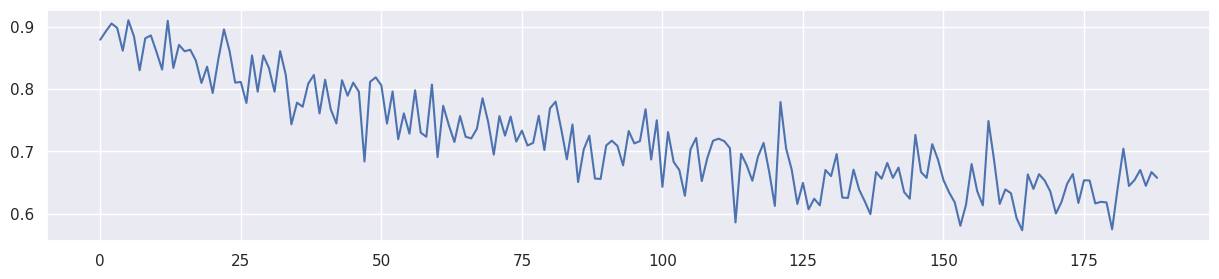

Mean F1 for all data: 0.7216342598590664
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 1.107801]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 0.833361] [G loss: 0.724797]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 0.213414] [G loss: 0.519434]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 0.195383] [G loss: 0.491674]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 0.200621] [G loss: 0.469555]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 0.206596] [G loss: 0.446452]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 0.213079] [G loss: 0.422978]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 0.219984] [G loss: 0.399436]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 0.226841] [G loss: 0.376687]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 0.234315] [G loss: 0.354238]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 0.241240] [G loss: 0.333452]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 0.247465] [G loss: 0.314807]
[Lambda: 0.300000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 617.52it/s]


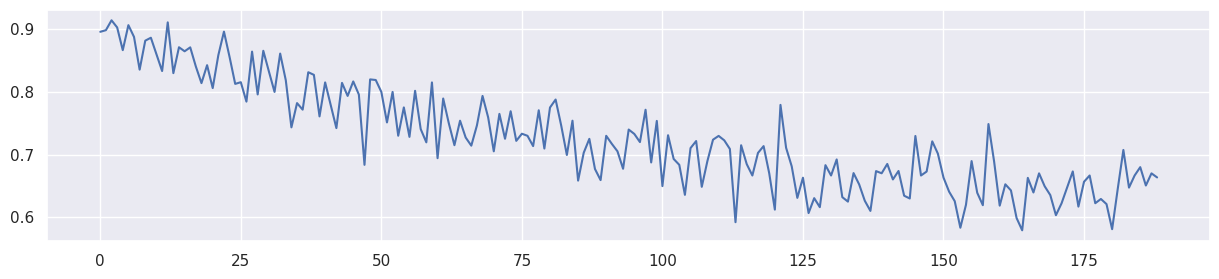

Mean F1 for all data: 0.7269675778448235
[Lambda: 0.400000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 1.245316]
[Lambda: 0.400000] [Epoch 200/4000] [D_F loss: 0.833172] [G loss: 0.740447]
[Lambda: 0.400000] [Epoch 400/4000] [D_F loss: 0.213155] [G loss: 0.476251]
[Lambda: 0.400000] [Epoch 600/4000] [D_F loss: 0.195186] [G loss: 0.449649]
[Lambda: 0.400000] [Epoch 800/4000] [D_F loss: 0.200202] [G loss: 0.431314]
[Lambda: 0.400000] [Epoch 1000/4000] [D_F loss: 0.205708] [G loss: 0.412349]
[Lambda: 0.400000] [Epoch 1200/4000] [D_F loss: 0.211478] [G loss: 0.393117]
[Lambda: 0.400000] [Epoch 1400/4000] [D_F loss: 0.217768] [G loss: 0.374099]
[Lambda: 0.400000] [Epoch 1600/4000] [D_F loss: 0.224006] [G loss: 0.355630]
[Lambda: 0.400000] [Epoch 1800/4000] [D_F loss: 0.230660] [G loss: 0.337731]
[Lambda: 0.400000] [Epoch 2000/4000] [D_F loss: 0.237458] [G loss: 0.321210]
[Lambda: 0.400000] [Epoch 2200/4000] [D_F loss: 0.243866] [G loss: 0.305842]
[Lambda: 0.400000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 590.25it/s]


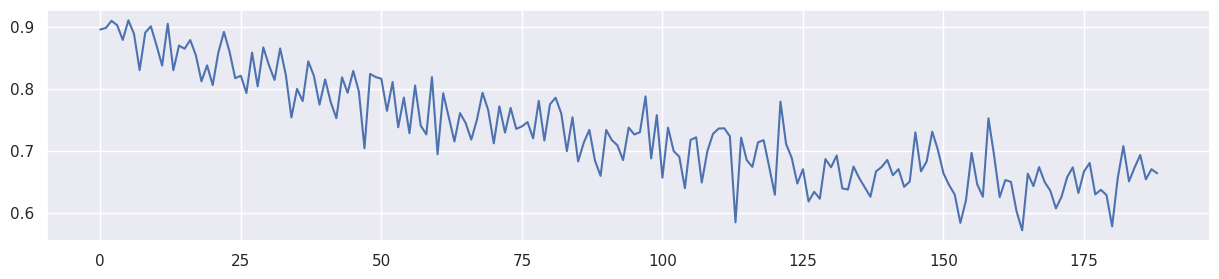

Mean F1 for all data: 0.7319763899719148
[Lambda: 0.500000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 1.382831]
[Lambda: 0.500000] [Epoch 200/4000] [D_F loss: 0.832889] [G loss: 0.756029]
[Lambda: 0.500000] [Epoch 400/4000] [D_F loss: 0.212725] [G loss: 0.433048]
[Lambda: 0.500000] [Epoch 600/4000] [D_F loss: 0.194867] [G loss: 0.407642]
[Lambda: 0.500000] [Epoch 800/4000] [D_F loss: 0.199480] [G loss: 0.393084]
[Lambda: 0.500000] [Epoch 1000/4000] [D_F loss: 0.204273] [G loss: 0.378121]
[Lambda: 0.500000] [Epoch 1200/4000] [D_F loss: 0.209030] [G loss: 0.363057]
[Lambda: 0.500000] [Epoch 1400/4000] [D_F loss: 0.214099] [G loss: 0.348410]
[Lambda: 0.500000] [Epoch 1600/4000] [D_F loss: 0.219668] [G loss: 0.334297]
[Lambda: 0.500000] [Epoch 1800/4000] [D_F loss: 0.225353] [G loss: 0.320795]
[Lambda: 0.500000] [Epoch 2000/4000] [D_F loss: 0.231430] [G loss: 0.308606]
[Lambda: 0.500000] [Epoch 2200/4000] [D_F loss: 0.237384] [G loss: 0.297326]
[Lambda: 0.500000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 599.26it/s]


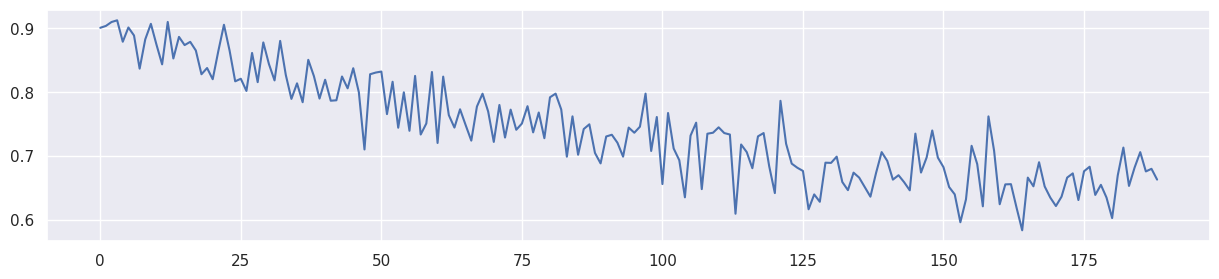

Mean F1 for all data: 0.7423708784087666
[Lambda: 0.600000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 1.520346]
[Lambda: 0.600000] [Epoch 200/4000] [D_F loss: 0.832396] [G loss: 0.771489]
[Lambda: 0.600000] [Epoch 400/4000] [D_F loss: 0.211923] [G loss: 0.389839]
[Lambda: 0.600000] [Epoch 600/4000] [D_F loss: 0.194212] [G loss: 0.365749]
[Lambda: 0.600000] [Epoch 800/4000] [D_F loss: 0.198079] [G loss: 0.354855]
[Lambda: 0.600000] [Epoch 1000/4000] [D_F loss: 0.201653] [G loss: 0.343617]
[Lambda: 0.600000] [Epoch 1200/4000] [D_F loss: 0.204925] [G loss: 0.332331]
[Lambda: 0.600000] [Epoch 1400/4000] [D_F loss: 0.208073] [G loss: 0.321580]
[Lambda: 0.600000] [Epoch 1600/4000] [D_F loss: 0.211207] [G loss: 0.311396]
[Lambda: 0.600000] [Epoch 1800/4000] [D_F loss: 0.214972] [G loss: 0.302308]
[Lambda: 0.600000] [Epoch 2000/4000] [D_F loss: 0.219893] [G loss: 0.294440]
[Lambda: 0.600000] [Epoch 2200/4000] [D_F loss: 0.225597] [G loss: 0.287040]
[Lambda: 0.600000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 611.76it/s]


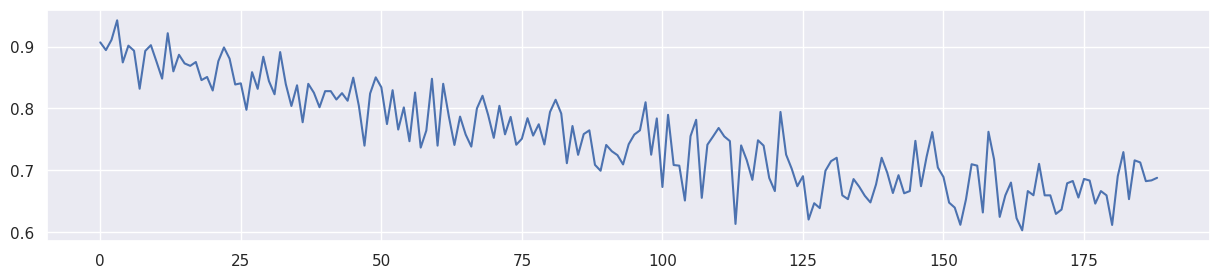

Mean F1 for all data: 0.7527575859274136
[Lambda: 0.700000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 1.657862]
[Lambda: 0.700000] [Epoch 200/4000] [D_F loss: 0.831427] [G loss: 0.786655]
[Lambda: 0.700000] [Epoch 400/4000] [D_F loss: 0.210112] [G loss: 0.346536]
[Lambda: 0.700000] [Epoch 600/4000] [D_F loss: 0.192568] [G loss: 0.324029]
[Lambda: 0.700000] [Epoch 800/4000] [D_F loss: 0.194762] [G loss: 0.316384]
[Lambda: 0.700000] [Epoch 1000/4000] [D_F loss: 0.195838] [G loss: 0.308375]
[Lambda: 0.700000] [Epoch 1200/4000] [D_F loss: 0.196137] [G loss: 0.300296]
[Lambda: 0.700000] [Epoch 1400/4000] [D_F loss: 0.195451] [G loss: 0.292440]
[Lambda: 0.700000] [Epoch 1600/4000] [D_F loss: 0.194416] [G loss: 0.285362]
[Lambda: 0.700000] [Epoch 1800/4000] [D_F loss: 0.194358] [G loss: 0.279568]
[Lambda: 0.700000] [Epoch 2000/4000] [D_F loss: 0.195843] [G loss: 0.275178]
[Lambda: 0.700000] [Epoch 2200/4000] [D_F loss: 0.198860] [G loss: 0.271833]
[Lambda: 0.700000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 609.15it/s]


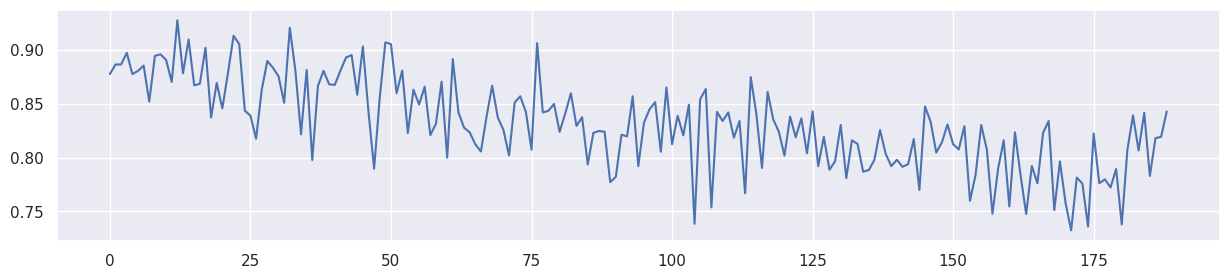

Mean F1 for all data: 0.8317235320413001
[Lambda: 0.800000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 1.795377]
[Lambda: 0.800000] [Epoch 200/4000] [D_F loss: 0.829699] [G loss: 0.801038]
[Lambda: 0.800000] [Epoch 400/4000] [D_F loss: 0.205401] [G loss: 0.301996]
[Lambda: 0.800000] [Epoch 600/4000] [D_F loss: 0.186129] [G loss: 0.281527]
[Lambda: 0.800000] [Epoch 800/4000] [D_F loss: 0.185560] [G loss: 0.276170]
[Lambda: 0.800000] [Epoch 1000/4000] [D_F loss: 0.180609] [G loss: 0.269275]
[Lambda: 0.800000] [Epoch 1200/4000] [D_F loss: 0.168396] [G loss: 0.259846]
[Lambda: 0.800000] [Epoch 1400/4000] [D_F loss: 0.153192] [G loss: 0.250935]
[Lambda: 0.800000] [Epoch 1600/4000] [D_F loss: 0.138238] [G loss: 0.244367]
[Lambda: 0.800000] [Epoch 1800/4000] [D_F loss: 0.126286] [G loss: 0.240322]
[Lambda: 0.800000] [Epoch 2000/4000] [D_F loss: 0.118502] [G loss: 0.238091]
[Lambda: 0.800000] [Epoch 2200/4000] [D_F loss: 0.113226] [G loss: 0.236786]
[Lambda: 0.800000] [Epoch 2400/4000] [D_F 

100%|██████████| 189/189 [00:00<00:00, 629.94it/s]


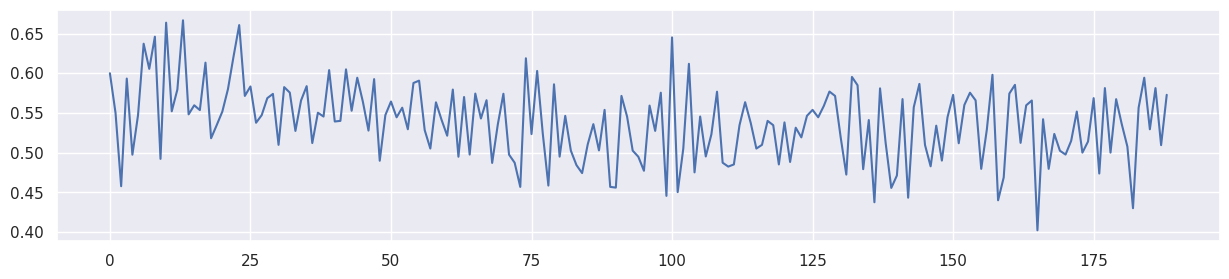

Mean F1 for all data: 0.5379336032555441
[Lambda: 0.900000] [Epoch 0/4000] [D_F loss: 2.070407] [G loss: 1.932892]
[Lambda: 0.900000] [Epoch 200/4000] [D_F loss: 0.826662] [G loss: 0.813539]
[Lambda: 0.900000] [Epoch 400/4000] [D_F loss: 0.199632] [G loss: 0.251200]
[Lambda: 0.900000] [Epoch 600/4000] [D_F loss: 0.174581] [G loss: 0.230232]
[Lambda: 0.900000] [Epoch 800/4000] [D_F loss: 0.165154] [G loss: 0.224741]
[Lambda: 0.900000] [Epoch 1000/4000] [D_F loss: 0.148569] [G loss: 0.214766]
[Lambda: 0.900000] [Epoch 1200/4000] [D_F loss: 0.124850] [G loss: 0.198967]
[Lambda: 0.900000] [Epoch 1400/4000] [D_F loss: 0.095280] [G loss: 0.179876]
[Lambda: 0.900000] [Epoch 1600/4000] [D_F loss: 0.062169] [G loss: 0.161178]
[Lambda: 0.900000] [Epoch 1800/4000] [D_F loss: 0.031257] [G loss: 0.146792]
[Lambda: 0.900000] [Epoch 2000/4000] [D_F loss: 0.006739] [G loss: 0.137536]
[Lambda: 0.900000] [Epoch 2200/4000] [D_F loss: -0.010526] [G loss: 0.131840]
[Lambda: 0.900000] [Epoch 2400/4000] [D_F

100%|██████████| 189/189 [00:00<00:00, 546.97it/s]


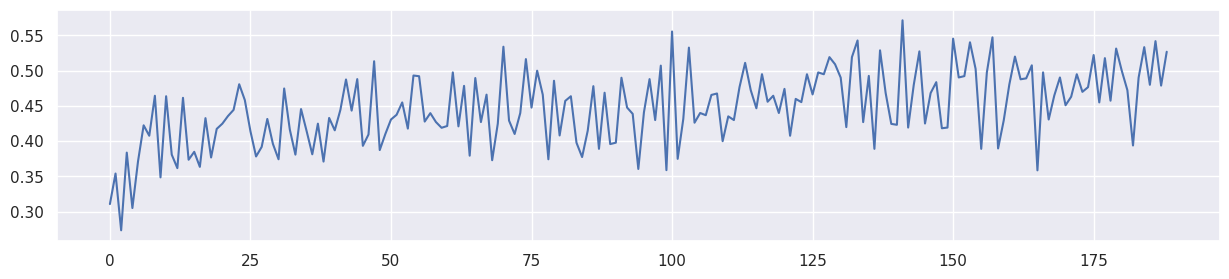

Mean F1 for all data: 0.4473343509454414


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.883721  0.718557  0.651163  0.245552
2        0.2  0.868571  0.879630  0.721634  0.657407  0.245552
3        0.3  0.868571  0.895928  0.726968  0.663594  0.245552
4        0.4  0.875000  0.895928  0.731976  0.663594  0.243805
5        0.5  0.870056  0.900901  0.742371  0.663551  0.228285
6        0.6  0.868571  0.906667  0.752758  0.688073  0.230407
7        0.7  0.822222  0.877828  0.831724  0.842975  0.130351
8        0.8  0.551020  0.600000  0.537934  0.572816  0.118774
9        0.9  0.335135  0.310881  0.447334  0.526829  0.369255

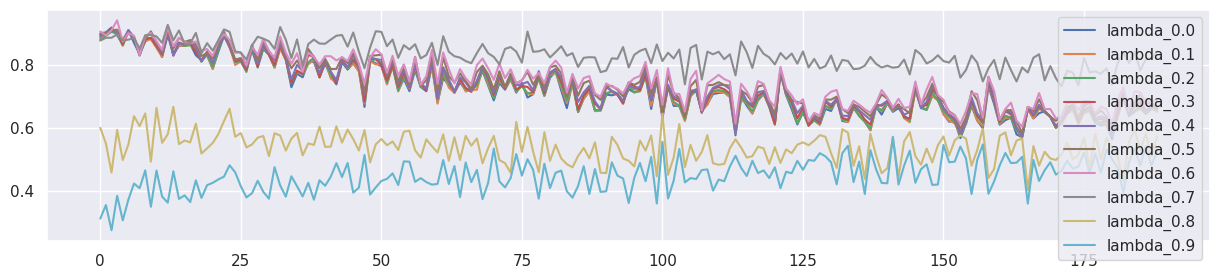

In [33]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model22(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)

result3_df = pd.DataFrame(result_table3)


pd.concat([result3_df, result2_df])


## MINE를 통해 I(y^,z) 측정

(40000, 5)
(40000,)


100%|██████████| 300/300 [00:00<00:00, 576.86it/s]

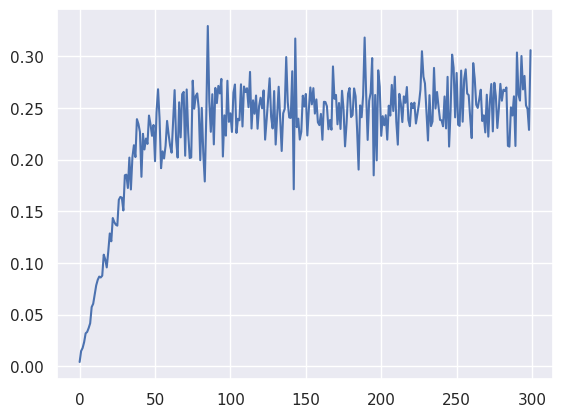

In [34]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 1000

x1 = X[0:1800][['z0']].values
y1 = y_train.data.numpy()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(x.shape)
print(y.shape)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    s = np.random.choice(x1.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x1[s].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y1[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1[s])).type(torch.FloatTensor), requires_grad = True)    
    ret = torch.mean(model(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model(x_sample, y_shuffle))))
    loss = - ret  # maximize
    model.zero_grad()
    loss.backward()
    optimizer.step()
    plot_loss.append(ret.data.numpy())


    #back_loss = loss

print('')

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss)

In [35]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    mine = Net()
    optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        #y1 = gen_y[s].data.numpy()
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = torch.abs(ret)  # maximize

        #mi_loss = mse_loss(torch.mean(mine(x_sample, y_sample)), torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle)))))
        #mi_loss = mse_loss(mine(x_sample, y_sample), mine(x_sample, y_shuffle))

        mine.zero_grad()
        #loss.backward()
        mi_losses.append(mi_loss)
        #optimizer_D_F.step()
        '''
        if epoch > int(n_epochs* lambda_f):
            optimizer_G.zero_grad()
            loss = (1-lambda_f) * g_loss * 0.1  + lambda_f * mi_loss 
            #loss = 0 * g_loss + lambda_f * mi_loss 
            loss.backward()
            optimizer_G.step()

        else:
            mi_loss.backward()
        '''
        optimizer_G.zero_grad()
        loss = (1-lambda_f) * g_loss   + lambda_f * (mi_loss * 1000) 
        #loss = 0 * g_loss + lambda_f * mi_loss 
        loss.backward()
        optimizer_G.step()
        
        optimizer.step()            


        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 189/189 [00:00<00:00, 613.83it/s]


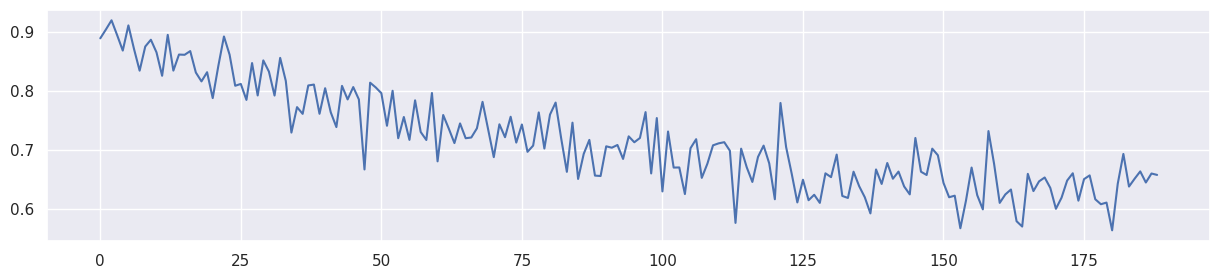

Mean F1 for all data: 0.7169960936024915
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 0.001382] [G loss: 0.695255]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 0.000010] [G loss: 0.690334]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 0.000005] [G loss: 0.679383]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 0.000002] [G loss: 0.657220]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 0.000165] [G loss: 0.632453]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 0.000012] [G loss: 0.604140]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 0.000028] [G loss: 0.571912]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 0.000010] [G loss: 0.537440]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 0.000009] [G loss: 0.502171]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 0.000027] [G loss: 0.466058]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 0.000015] [G loss: 0.430721]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 0.000007] [G loss: 0.396640]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: 0.00001

100%|██████████| 189/189 [00:00<00:00, 590.23it/s]


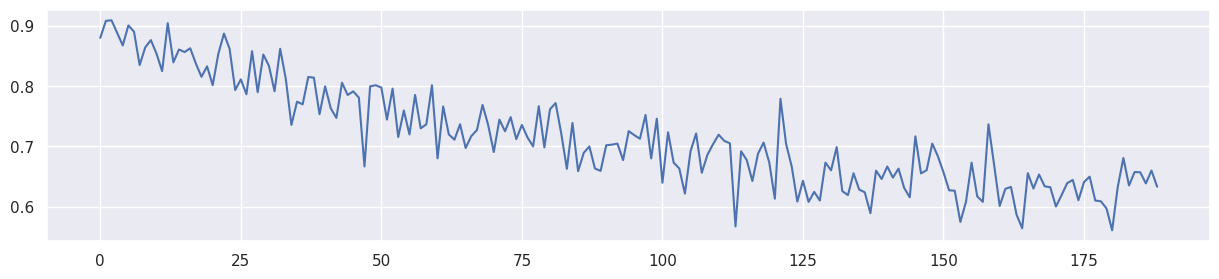

Mean F1 for all data: 0.7158778973332484
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 0.001319] [G loss: 0.695255]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 0.000010] [G loss: 0.693658]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 0.000021] [G loss: 0.689249]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 0.000008] [G loss: 0.681604]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 0.000069] [G loss: 0.668535]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 0.000002] [G loss: 0.653010]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 0.000017] [G loss: 0.634499]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 0.000004] [G loss: 0.610496]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 0.000006] [G loss: 0.581540]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 0.000046] [G loss: 0.549531]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 0.000004] [G loss: 0.517180]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 0.000042] [G loss: 0.483683]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 189/189 [00:00<00:00, 606.64it/s]


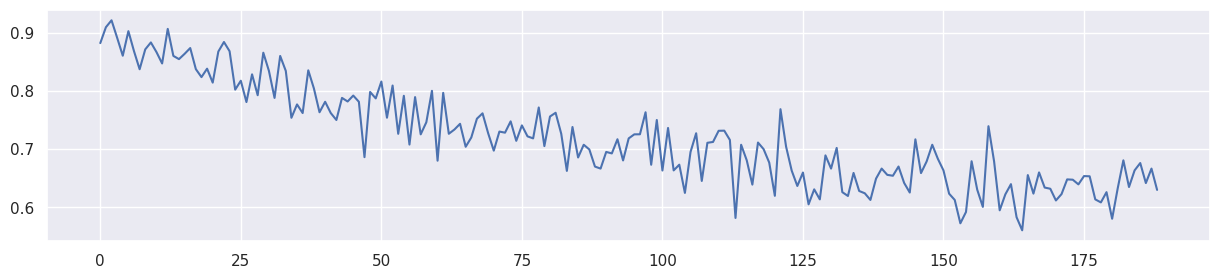

Mean F1 for all data: 0.7203258748044296
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 0.001269] [G loss: 0.695255]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 0.000017] [G loss: 0.694429]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 0.000016] [G loss: 0.693279]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 0.000003] [G loss: 0.689851]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 0.000033] [G loss: 0.687518]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 0.000002] [G loss: 0.682865]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 0.000011] [G loss: 0.674149]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 0.000014] [G loss: 0.663494]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 0.000029] [G loss: 0.649282]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 0.000002] [G loss: 0.632431]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 0.000002] [G loss: 0.612124]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 0.000006] [G loss: 0.587677]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: 0.00001

100%|██████████| 189/189 [00:00<00:00, 619.08it/s]


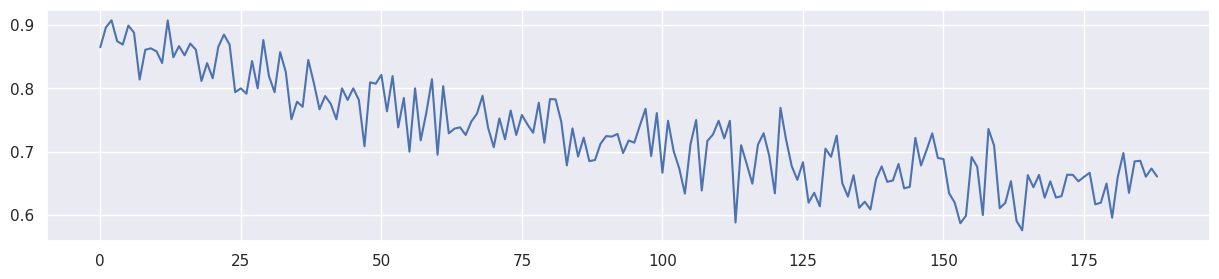

Mean F1 for all data: 0.7289288333993694
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 0.001424] [G loss: 0.695255]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.000215] [G loss: 0.694740]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.000029] [G loss: 0.694059]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.000018] [G loss: 0.692535]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.000019] [G loss: 0.689674]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.000005] [G loss: 0.688165]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.000004] [G loss: 0.683741]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.000036] [G loss: 0.677924]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.000007] [G loss: 0.671604]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.000001] [G loss: 0.662657]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.000003] [G loss: 0.651120]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.000012] [G loss: 0.638011]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0.00002

100%|██████████| 189/189 [00:00<00:00, 571.50it/s]


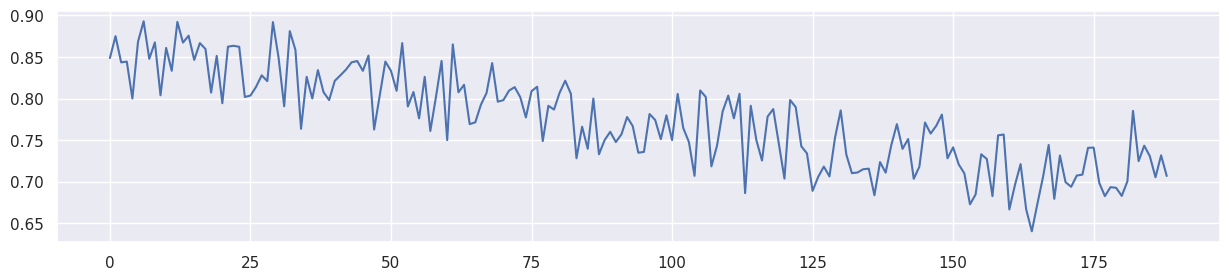

Mean F1 for all data: 0.7740763177739197
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 0.001455] [G loss: 0.695255]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.000073] [G loss: 0.695005]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.000008] [G loss: 0.694270]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.000015] [G loss: 0.693995]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.000005] [G loss: 0.692222]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.000014] [G loss: 0.689420]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.000002] [G loss: 0.685742]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.000005] [G loss: 0.679810]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.000002] [G loss: 0.672650]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.000012] [G loss: 0.663090]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.000010] [G loss: 0.650979]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.000067] [G loss: 0.636673]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 189/189 [00:00<00:00, 558.50it/s]


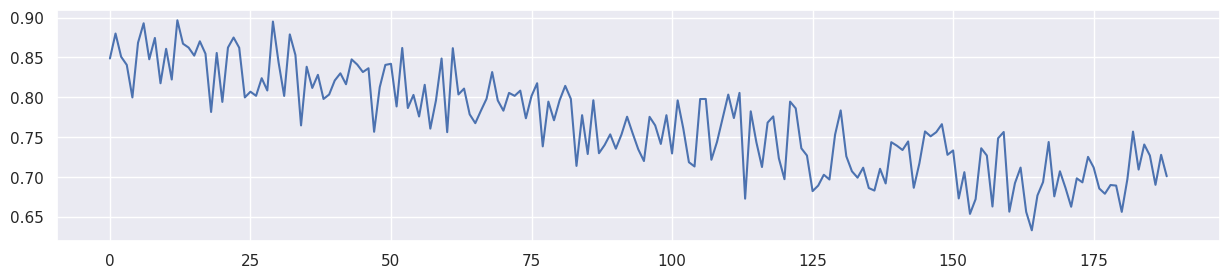

Mean F1 for all data: 0.7680861867381144
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 0.001429] [G loss: 0.695255]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 0.000005] [G loss: 0.695211]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 0.000020] [G loss: 0.694588]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 0.000128] [G loss: 0.694237]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 0.000006] [G loss: 0.693217]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 0.000003] [G loss: 0.691246]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 0.000003] [G loss: 0.689391]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 0.000013] [G loss: 0.687028]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 0.000006] [G loss: 0.683353]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 0.000000] [G loss: 0.679777]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 0.000006] [G loss: 0.676561]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 0.000002] [G loss: 0.672366]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 189/189 [00:00<00:00, 603.54it/s]


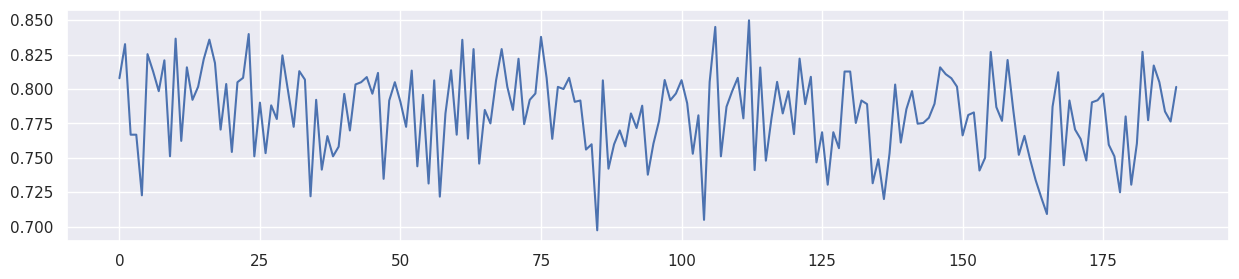

Mean F1 for all data: 0.7825877661235514
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 0.001458] [G loss: 0.695255]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.000010] [G loss: 0.695013]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 0.000020] [G loss: 0.694769]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 0.000003] [G loss: 0.694367]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 0.000009] [G loss: 0.693828]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 0.000015] [G loss: 0.693079]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 0.000000] [G loss: 0.691196]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 0.000003] [G loss: 0.689362]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 0.000004] [G loss: 0.686561]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 0.000004] [G loss: 0.681772]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 0.000011] [G loss: 0.676662]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 0.000003] [G loss: 0.672204]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 0.00004

100%|██████████| 189/189 [00:00<00:00, 623.07it/s]


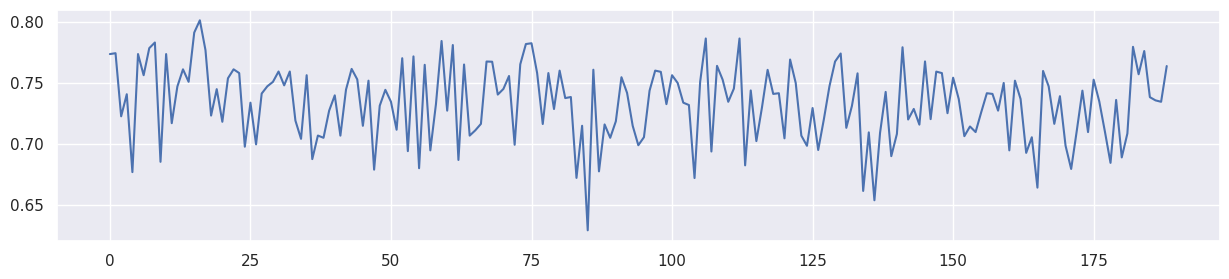

Mean F1 for all data: 0.7332724195581002
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 0.001429] [G loss: 0.695255]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.000043] [G loss: 0.695260]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 0.000002] [G loss: 0.695046]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 0.000006] [G loss: 0.694836]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 0.000004] [G loss: 0.694473]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 0.000026] [G loss: 0.694224]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 0.000052] [G loss: 0.693528]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 0.000004] [G loss: 0.693063]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 0.000009] [G loss: 0.692699]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 0.000013] [G loss: 0.691341]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 0.000001] [G loss: 0.690499]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 0.000001] [G loss: 0.689991]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 189/189 [00:00<00:00, 622.96it/s]


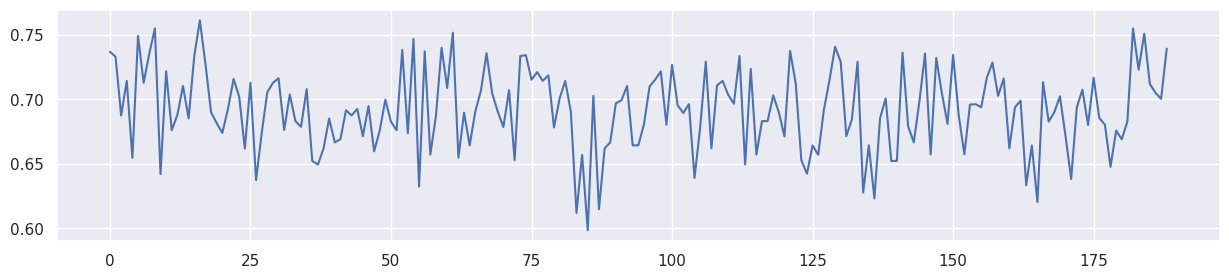

Mean F1 for all data: 0.6919349297045316
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 0.001462] [G loss: 0.695255]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.000037] [G loss: 0.695146]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 0.000002] [G loss: 0.694899]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 0.000029] [G loss: 0.694744]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 0.000027] [G loss: 0.694685]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 0.000021] [G loss: 0.694648]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 0.000044] [G loss: 0.694386]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 0.000015] [G loss: 0.694158]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 0.000011] [G loss: 0.693777]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 0.000010] [G loss: 0.693623]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 0.000002] [G loss: 0.693404]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 0.000001] [G loss: 0.693208]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: 0.00000

100%|██████████| 189/189 [00:00<00:00, 602.27it/s]


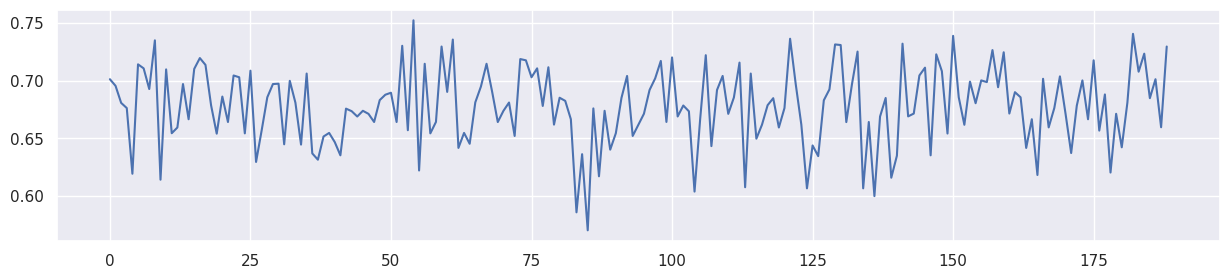

Mean F1 for all data: 0.6779981814202746


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.883721  0.718557  0.651163  0.245552
2        0.2  0.868571  0.879630  0.721634  0.657407  0.245552
3        0.3  0.868571  0.895928  0.726968  0.663594  0.245552
4        0.4  0.875000  0.895928  0.731976  0.663594  0.243805
5        0.5  0.870056  0.900901  0.742371  0.663551  0.228285
6        0.6  0.868571  0.906667  0.752758  0.688073  0.230407
7        0.7  0.822222  0.877828  0.831724  0.842975  0.130351
8        0.8  0.551020  0.600000  0.537934  0.572816  0.118774
9        0.9  0.335135  0.310881  0.447334  0.526829  0.369255
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.881356  0.880734  0.715878  0.633028  0.258235
2        0.2  0.882682  0.881818  0.720326  0.630137  0.280927
3        0.3  0.864865  0.864865  0.728929  0.660793  0.242123
4        0.4  0.794118  0.848739  0.774076  0.706897  0.093596
5        0.5  0.805970  0.848739  0.768086  0.701299  0.113515
6        0.6  0.700422  0.807843  0.782588  0.801556  0.012120
7        0.7  0.656250  0.773723  0.733272  0.763889  0.001996
8        0.8  0.631970  0.736842  0.691935  0.739274  0.019937
9        0.9  0.639098  0.701389  0.677998  0.729730  0.000000

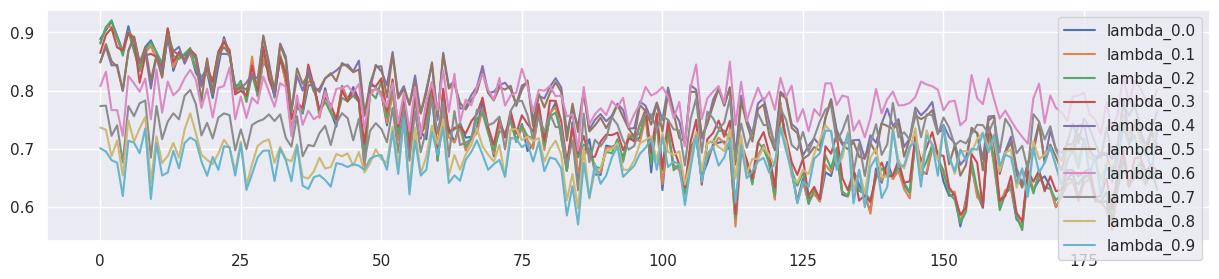

In [36]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]# Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.4,0.8]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



In [37]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model4(train_tensors, test_tensors, train_opt, lambda_f, seed,alpha):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    mine = Net()
    optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        #y1 = gen_y[s].data.numpy()  # y^의 샘플
        #y2 = y_train[s].data.numpy().reshape(-1,1) # y의 샘플
        #print('y1',y1.shape)
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        y2_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
        y2_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret2(y의 샘플)는 maximize 하야 하고
        # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret2 + torch.abs(ret1)

        #mi_loss = mse_loss(torch.mean(mine(x_sample, y_sample)), torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle)))))
        #mi_loss = mse_loss(mine(x_sample, y_sample), mine(x_sample, y_shuffle))

        mine.zero_grad()
        #loss.backward()
        mi_losses.append(-ret2)
        #optimizer_D_F.step()
        '''
        if epoch > int(n_epochs* lambda_f):
            optimizer_G.zero_grad()
            loss = (1-lambda_f) * g_loss * 0.1  + lambda_f * mi_loss 
            #loss = 0 * g_loss + lambda_f * mi_loss 
            loss.backward()
            optimizer_G.step()

        else:
            mi_loss.backward()
        '''
        optimizer_G.zero_grad()
        loss = (1-lambda_f) * g_loss  + lambda_f * mi_loss * alpha
        #loss = 0 * g_loss + lambda_f * mi_loss 
        loss.backward()
        optimizer_G.step()
        
        optimizer.step()            


        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.695255]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.677657]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.648799]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.617496]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.583921]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.548074]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.511307]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.474273]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.402506]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.369965]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.341810]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.317959]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.297297]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.279801]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.265788]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.255069]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.247021]

100%|██████████| 189/189 [00:00<00:00, 609.20it/s]


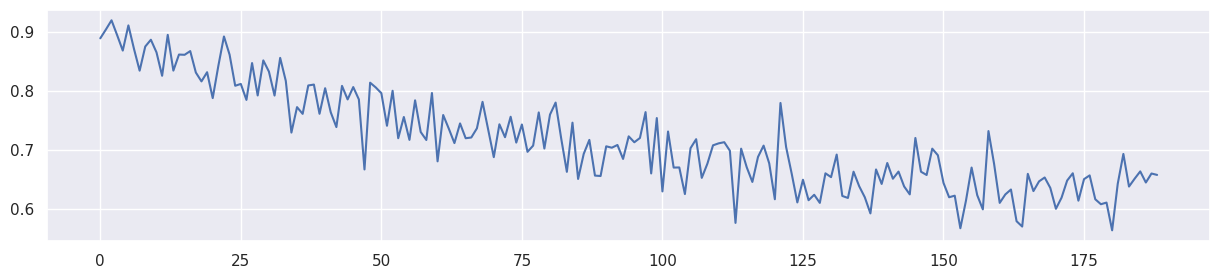

Mean F1 for all data: 0.7169960936024915
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: -0.000739] [G loss: 0.695255]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: -0.222204] [G loss: 0.678285]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: -0.238811] [G loss: 0.650699]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: -0.240417] [G loss: 0.619741]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: -0.264929] [G loss: 0.586266]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: -0.244452] [G loss: 0.551068]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: -0.287771] [G loss: 0.515156]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: -0.231075] [G loss: 0.478964]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: -0.227044] [G loss: 0.443394]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: -0.294317] [G loss: 0.408887]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: -0.259852] [G loss: 0.376677]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: -0.256305] [G loss: 0.348601]
[Lambda: 0.100000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 626.11it/s]


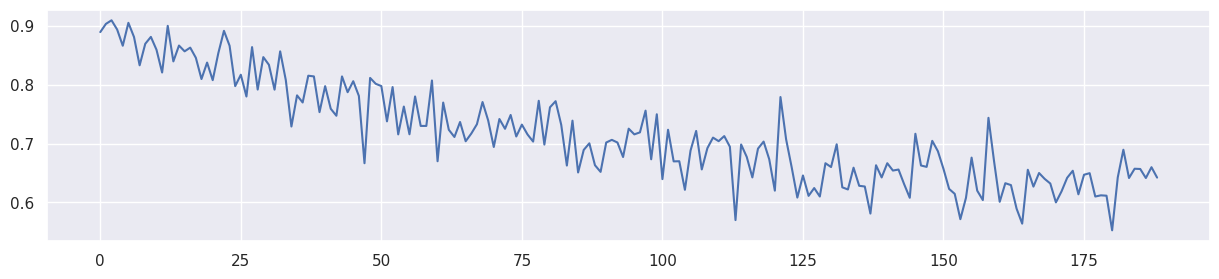

Mean F1 for all data: 0.7166172688706061
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: -0.000677] [G loss: 0.695255]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: -0.244677] [G loss: 0.679501]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: -0.282805] [G loss: 0.654145]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: -0.241375] [G loss: 0.624884]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: -0.248786] [G loss: 0.592981]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: -0.284136] [G loss: 0.559478]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: -0.232819] [G loss: 0.525525]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: -0.213839] [G loss: 0.491554]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: -0.218476] [G loss: 0.457743]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: -0.270564] [G loss: 0.425254]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: -0.284400] [G loss: 0.394681]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: -0.252321] [G loss: 0.367165]
[Lambda: 0.200000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 624.35it/s]


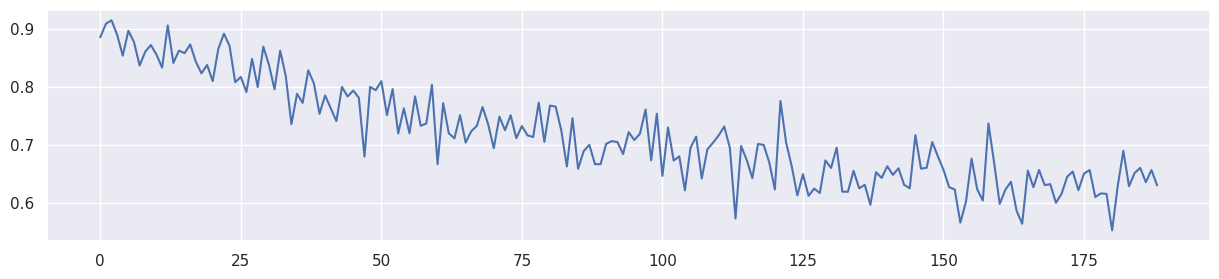

Mean F1 for all data: 0.7174690302009036
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: -0.000742] [G loss: 0.695255]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: -0.248091] [G loss: 0.681491]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: -0.269549] [G loss: 0.659951]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: -0.175454] [G loss: 0.632493]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: -0.278666] [G loss: 0.602481]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: -0.255791] [G loss: 0.571119]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: -0.270997] [G loss: 0.539707]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: -0.296688] [G loss: 0.508968]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: -0.265802] [G loss: 0.479028]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: -0.211619] [G loss: 0.450317]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: -0.186815] [G loss: 0.422123]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: -0.224808] [G loss: 0.395891]
[Lambda: 0.300000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 626.36it/s]


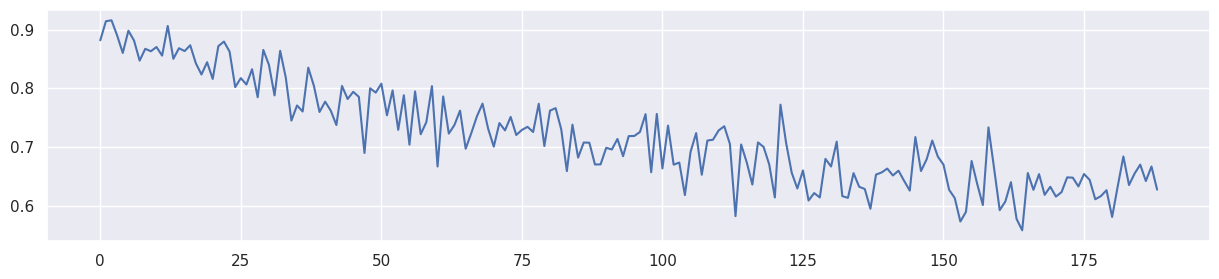

Mean F1 for all data: 0.7196030360170174
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: -0.000893] [G loss: 0.695255]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: -0.274784] [G loss: 0.682686]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: -0.277081] [G loss: 0.668278]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: -0.213880] [G loss: 0.645728]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: -0.207111] [G loss: 0.620046]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: -0.242759] [G loss: 0.593142]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: -0.237378] [G loss: 0.565520]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: -0.266545] [G loss: 0.538024]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: -0.284597] [G loss: 0.511460]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: -0.206707] [G loss: 0.485975]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: -0.236530] [G loss: 0.461289]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: -0.244584] [G loss: 0.437275]
[Lambda: 0.400000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 621.62it/s]


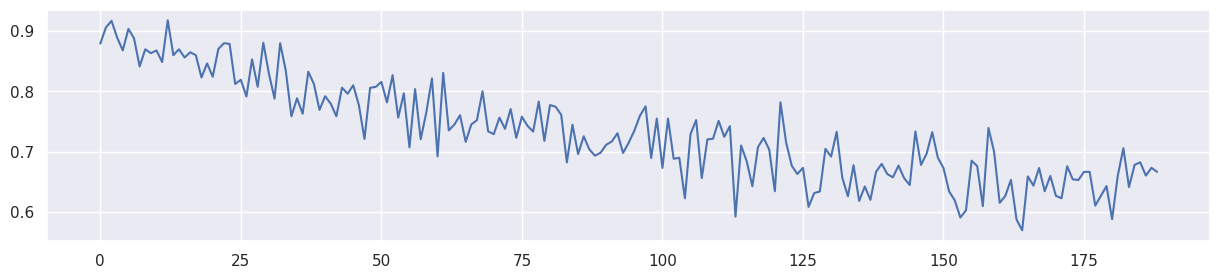

Mean F1 for all data: 0.7327053151379584
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: -0.000846] [G loss: 0.695255]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: -0.274440] [G loss: 0.683831]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: -0.263487] [G loss: 0.674695]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: -0.271410] [G loss: 0.662373]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: -0.228253] [G loss: 0.643162]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: -0.271218] [G loss: 0.620710]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: -0.254863] [G loss: 0.597432]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: -0.280986] [G loss: 0.573249]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: -0.269352] [G loss: 0.549477]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: -0.194787] [G loss: 0.526691]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: -0.258177] [G loss: 0.504597]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: -0.247101] [G loss: 0.485078]
[Lambda: 0.500000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 622.37it/s]


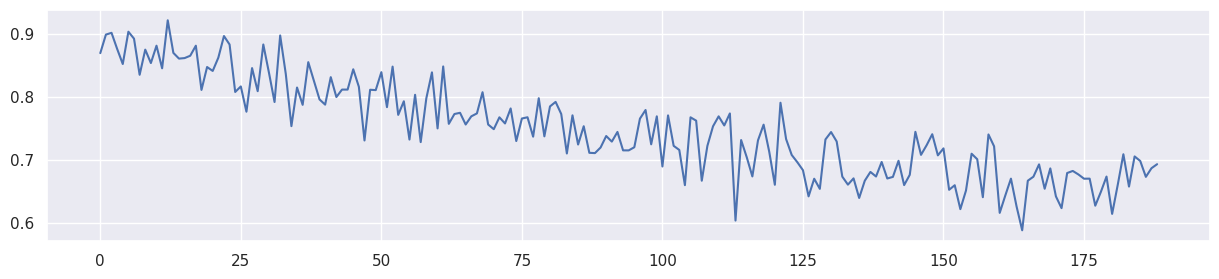

Mean F1 for all data: 0.748698044512991
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: -0.000558] [G loss: 0.695255]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: -0.236392] [G loss: 0.684281]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: -0.261557] [G loss: 0.678292]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: -0.268044] [G loss: 0.670915]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: -0.266929] [G loss: 0.661975]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: -0.259819] [G loss: 0.650994]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: -0.228232] [G loss: 0.637667]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: -0.300358] [G loss: 0.622264]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: -0.279971] [G loss: 0.604267]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: -0.242470] [G loss: 0.584731]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: -0.306077] [G loss: 0.565758]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: -0.275019] [G loss: 0.547496]
[Lambda: 0.600000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 574.64it/s]


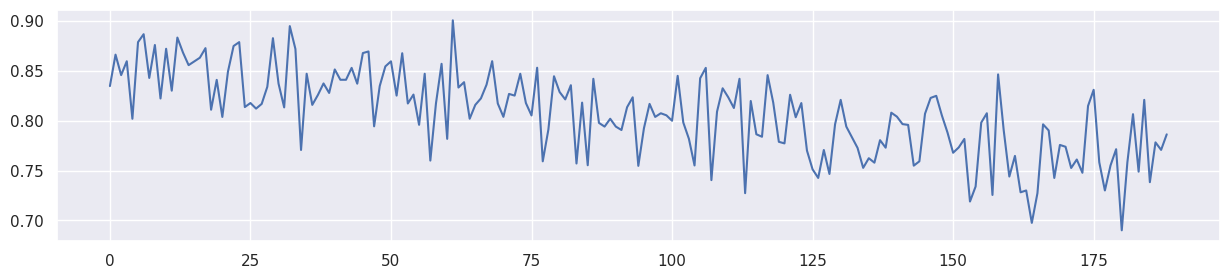

Mean F1 for all data: 0.8071752353265313
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: -0.000891] [G loss: 0.695255]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: -0.269727] [G loss: 0.685879]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: -0.256411] [G loss: 0.682895]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: -0.293208] [G loss: 0.679686]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: -0.263828] [G loss: 0.675887]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: -0.221186] [G loss: 0.670902]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: -0.280141] [G loss: 0.664660]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: -0.231352] [G loss: 0.656291]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: -0.221435] [G loss: 0.646488]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: -0.223403] [G loss: 0.635751]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: -0.305565] [G loss: 0.624539]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: -0.248135] [G loss: 0.612382]
[Lambda: 0.700000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 604.04it/s]


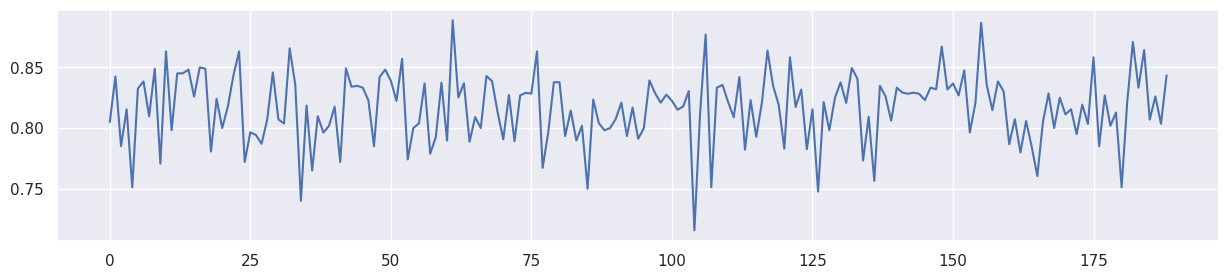

Mean F1 for all data: 0.8163603100880936
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: -0.000439] [G loss: 0.695255]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: -0.286964] [G loss: 0.686221]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: -0.252939] [G loss: 0.684601]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: -0.257779] [G loss: 0.683090]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: -0.239104] [G loss: 0.681463]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: -0.243798] [G loss: 0.679242]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: -0.221941] [G loss: 0.677782]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: -0.253339] [G loss: 0.675822]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: -0.223547] [G loss: 0.673817]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: -0.285081] [G loss: 0.671533]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: -0.309513] [G loss: 0.668124]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: -0.268052] [G loss: 0.664647]
[Lambda: 0.800000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 599.57it/s]


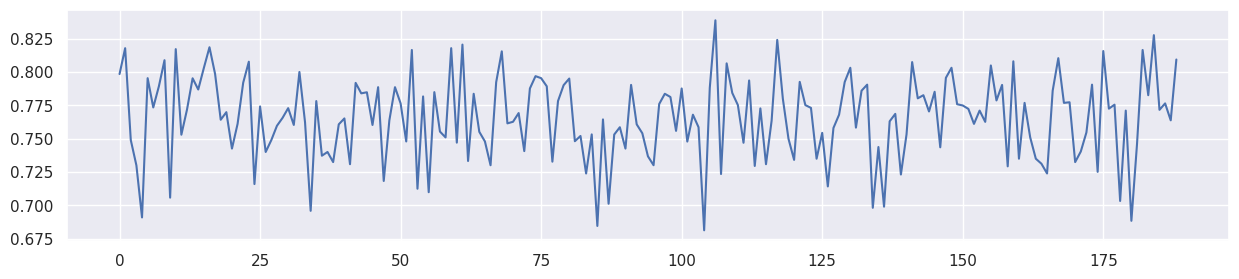

Mean F1 for all data: 0.7655781832131313
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: -0.000790] [G loss: 0.695255]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: -0.240979] [G loss: 0.687310]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: -0.261700] [G loss: 0.686773]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: -0.274194] [G loss: 0.686737]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: -0.222383] [G loss: 0.686412]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: -0.275843] [G loss: 0.686157]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: -0.224144] [G loss: 0.685774]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: -0.261649] [G loss: 0.685363]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: -0.263810] [G loss: 0.685633]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: -0.242641] [G loss: 0.685304]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: -0.241087] [G loss: 0.685452]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: -0.205416] [G loss: 0.685417]
[Lambda: 0.900000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 593.84it/s]


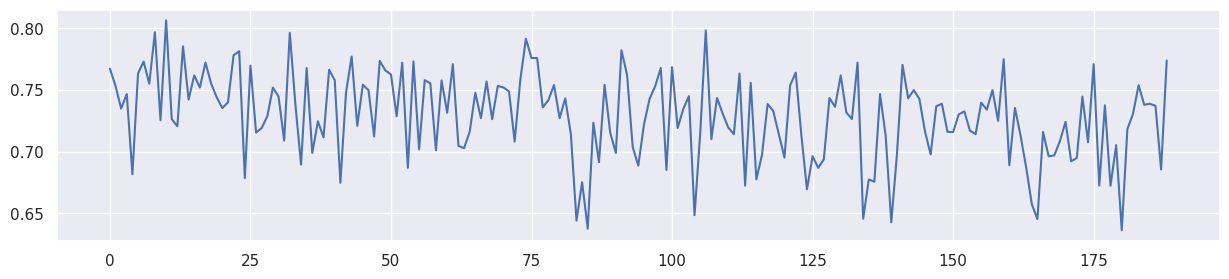

Mean F1 for all data: 0.7293198570413684


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.883721  0.718557  0.651163  0.245552
2        0.2  0.868571  0.879630  0.721634  0.657407  0.245552
3        0.3  0.868571  0.895928  0.726968  0.663594  0.245552
4        0.4  0.875000  0.895928  0.731976  0.663594  0.243805
5        0.5  0.870056  0.900901  0.742371  0.663551  0.228285
6        0.6  0.868571  0.906667  0.752758  0.688073  0.230407
7        0.7  0.822222  0.877828  0.831724  0.842975  0.130351
8        0.8  0.551020  0.600000  0.537934  0.572816  0.118774
9        0.9  0.335135  0.310881  0.447334  0.526829  0.369255
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.889908  0.716617  0.642202  0.245552
2        0.2  0.870056  0.885845  0.717469  0.630137  0.272083
3        0.3  0.877778  0.881818  0.719603  0.627273  0.265105
4        0.4  0.872928  0.878924  0.732705  0.666667  0.264776
5        0.5  0.844920  0.869955  0.748698  0.692982  0.197445
6        0.6  0.790000  0.834783  0.807175  0.786325  0.058841
7        0.7  0.775701  0.804979  0.816360  0.843478  0.027359
8        0.8  0.691667  0.798450  0.765578  0.809339  0.000000
9        0.9  0.694064  0.767347  0.729320  0.773946  0.006725

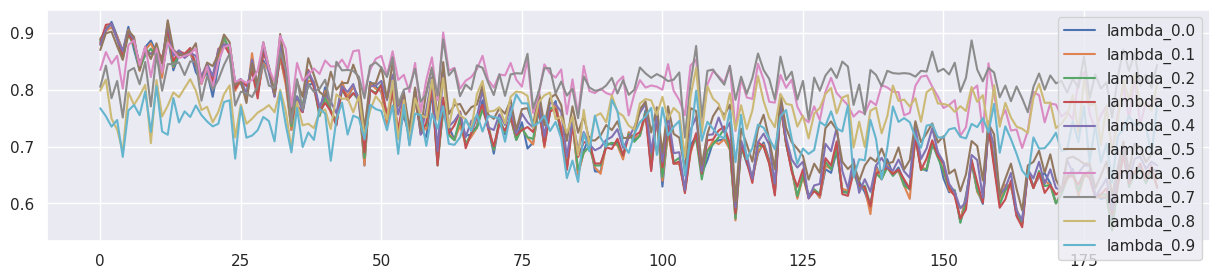

In [38]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]# Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.4,0.8]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model4(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.2)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



# GAN 기반의 RF-Train이 아닌, G(Z,B) 모델에서 전처리 학습 방법 적용
+ GAN 기번의 RF-Train 응용 방법은 일종의 orver-fitting을 막는 방법론에 해당한다.
+ 즉, trainset의 z에 over-fitting되어 이후 live data에 대해 성능이 저하되는 현상을 막도록하는 방법이다.
+ 따라서 이 방법은 결정적으로 test_f1 및 init_f1을 낮게 (z를 포함한 모든 feature을 학습하는 일반적인 학습방법에 비하여) 하는 결점을 갖는다.
+ 그렇다면, 이를 극복하며 live data의 성능도 떨어지지 않게 하는 방법은 무엇인가?
+ 본 chapter에서는 G(Z,B)를 입력으로 갖는 구조. 즉, bucket number와 z의 관계를 학습하여 전처리의 개념으로 새로 생성된 g를 z에 대신하여 D(x,g)에 입력하여 학습하는 모델을 제안한다.

## D(x,G(z,b)) 구조


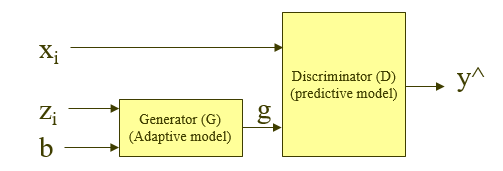

<pre>
x0 -------------------------------------> |                        |
x1 -------------------------------------> |                        |
x2 -------------------------------------> | Discriminator (D(x,g)) | -> y^
x3 -------------------------------------> | predictive model       |
z0 ------>| Generator (G(z,b)) | -- g --> |                        |
b  ------>| adaptive model     |
</pre>

+ 상기 구조의 loss function

$$
L_1 = H(y,\hat{y}) = H(y,D(x,G(z,b)))=\mathbb{E}_{y}[-log(D(x,G(z,b)))]
$$

$$
L_2 = MSE(G(z,b),z)
$$

$$
\min_{G(.)} (1-λ) L_1 + λ L_2
$$


+ 위의 loss function에서, lambda가 0이면 $L_1$의 backward 에서 D를 거쳐 G까지 학습이 이루어 진다. 
+ lambda가 0~1 사이의 값인 경우, G의 생성이 b의 값을 무시하는 방향으로 학습된다. 즉, feature 5개 입력의 특성에 근접, 다시말해 over-fitting의 효과로 학습된다.

In [39]:
X

x0        x1        x2        x3        z0    b
0      2.231833  0.663053  2.160447  1.180836  1.125117    0
1      1.326272  2.285045  2.362769  2.638806  2.171340    0
2      1.845348  3.743190  3.310210  1.772473  2.576518    0
3      2.974414 -0.229197  1.024580  1.387895  0.873782    0
4      2.854022  3.102544  1.610779  1.774781  2.490660    0
...         ...       ...       ...       ...       ...  ...
39995  0.085122 -0.571732  1.527233  1.867146 -1.177338  399
39996  1.069521 -0.221247  1.324087  1.798258  4.045168  399
39997  0.429295  2.593988  2.329410  1.859496  1.785665  399
39998  1.611266 -0.588687 -0.591898  2.126287  9.291351  399
39999  3.872531  0.931353  3.595759  1.948642  7.307901  399

[40000 rows x 6 columns]

In [40]:
mi_scores = make_mi_scores(X[['x0','x1','x2','x3','z0']], X['b'], discrete_features="auto")
print(mi_scores)

z0    0.163087
x0    0.000000
x1    0.000000
x2    0.000000
x3    0.000000
Name: MI Scores, dtype: float64


+ I(Z,B) 만 0.16의 수치가 나오는 것을 확인 할 수 있음!!!!
+ 즉, Z는 시간에 따라 importance가 변하고 있음.... -> Concept drift의 발생 요소  

In [41]:
# 학습셋에서의 I(Z,B)

mi_scores = make_mi_scores(X[0:2000][['x0','x1','x2','x3','z0']], X[0:2000]['b'], discrete_features="auto")
print(mi_scores)

x3    0.020639
x2    0.010275
x0    0.000000
x1    0.000000
z0    0.000000
Name: MI Scores, dtype: float64


+ 감지 안됨!!!!

(40000, 5)
(40000,)


100%|██████████| 5000/5000 [00:08<00:00, 595.14it/s]



0.0058872644


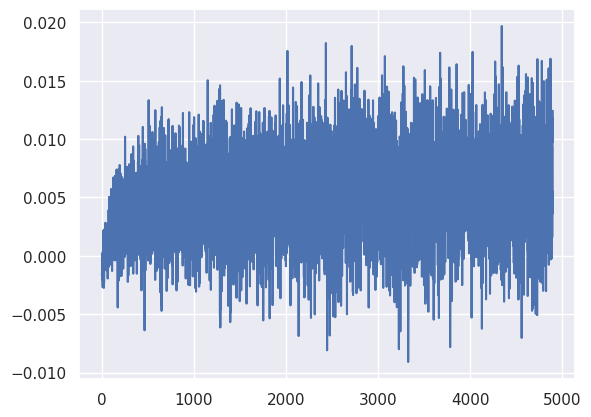

In [42]:
from tqdm import tqdm

H=20
n_epoch = 5000
minibatch = 1000

x1 = X[0:2000][['z0']].values
y1 = X[0:2000][['b']].values #y_train.data.numpy()

#x1 = X[['z0']].values
#y1 = X[['b']].values #y_train.data.numpy()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(x.shape)
print(y.shape)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    s = np.random.choice(x1.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x1[s].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y1[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1[s])).type(torch.FloatTensor), requires_grad = True)    
    ret = torch.mean(model(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model(x_sample, y_shuffle))))
    loss = - ret  # maximize
    model.zero_grad()
    loss.backward()
    optimizer.step()
    plot_loss.append(ret.data.numpy())


    #back_loss = loss

print('')

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss[100:])
print(np.mean(plot_loss[4000:]))

+ 유의미하게 감지되지 않음.....
+ 잘 안될거 같은데...

In [43]:
avaible_range = 400

In [146]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):
   
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(Sensitivity_Adapter, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
            #nn.ReLU(),
            #nn.Linear(5, 1)          
        )

    def forward(self, z0,b):

        adjusted_z = self.model(torch.cat((z0,b), 1))
        return adjusted_z

In [45]:

def test_model2(model_,model2_, tX, ty, s1):
    model_.eval()
    model2_.eval()

    a_z = model2_(tX[:,4].reshape(-1,1),tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(torch.cat((tX[:,0:4],a_z.reshape(-1,1)),1))
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [46]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model5(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter()
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net()
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  MINE -> I(Z,B)의 측정
        # -------------------------------
        '''
        s = np.random.choice(XS_train.shape[0],minibatch)

        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = XS_train[s][:,5].reshape(-1,1) # bucket number.. B
        y_shuffle = XS_train[np.random.permutation(s)][:,5].reshape(-1,1) #permute bucket number.. B
        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = - ret1

        ibz = torch.full((XS_train.shape[0],1), ret1.data.numpy())
        '''
        a_z = adapter(XS_train[:,4].reshape(-1,1) ,XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = mse_loss(a_z, XS_train[:,5].reshape(-1,1)) 

        # -------------------
        #  Forwards Generator
        # -------------------
        xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model2(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator,adapter

In [47]:
def test_all_data3(generator,train_size):

    XT = X[train_size:][['x0','x1','x2','x3','z0']]
    yT = y[train_size:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            #xs = adapter(tmp_x[:,4].reshape(-1,1),tmp_x[:,5].reshape(-1,1)).reshape(-1,1)
            predicted_y = generator(tmp_x)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [48]:
def test_all_data2(generator,adapter,train_size):

    XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    yT = y[train_size:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            xs = adapter(tmp_x[:,4].reshape(-1,1),tmp_x[:,5].reshape(-1,1)/avaible_range).reshape(-1,1)
            predicted_y = generator(torch.cat((tmp_x[:,0:4],xs),1))
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 154.804932] [G loss: 0.640260]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 203.462204] [G loss: 0.533527]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 278.115875] [G loss: 0.437781]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 347.719299] [G loss: 0.399955]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 326.328857] [G loss: 0.372155]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 305.419800] [G loss: 0.347418]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 269.400269] [G loss: 0.323205]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 231.109024] [G loss: 0.293631]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 242.998520] [G loss: 0.267753]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 265.420013] [G loss: 0.251776]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 284.450500] [G loss: 0.242791]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 300.845459] [G loss: 0.23

100%|██████████| 189/189 [00:00<00:00, 520.55it/s]


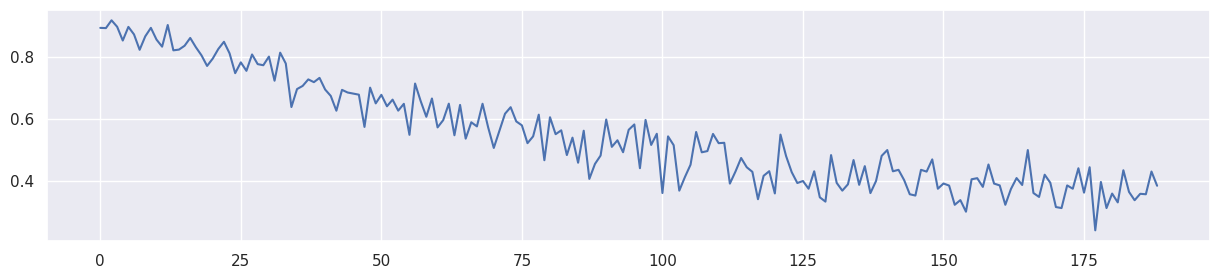

Mean F1 for all data: 0.5498654994787111
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 131.352264] [G loss: 0.640011]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 184.306702] [G loss: 0.524523]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 252.960693] [G loss: 0.432457]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 295.107513] [G loss: 0.397121]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 260.061462] [G loss: 0.370428]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 219.034897] [G loss: 0.341338]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 174.512680] [G loss: 0.314699]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 150.774368] [G loss: 0.280777]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 147.561905] [G loss: 0.257986]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 139.469788] [G loss: 0.245753]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 130.505951] [G loss: 0.237960]
[Lambda: 0.100000] [Epoch 2400/

100%|██████████| 189/189 [00:00<00:00, 540.23it/s]


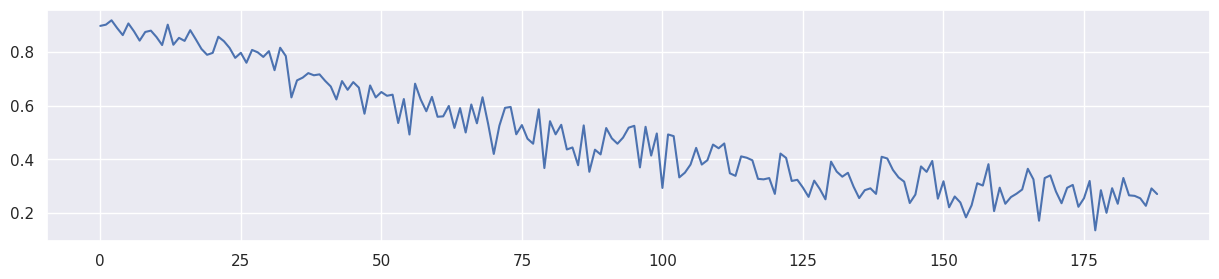

Mean F1 for all data: 0.4936137658085941
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 126.303925] [G loss: 0.639769]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 179.054108] [G loss: 0.523821]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 241.543228] [G loss: 0.432423]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 261.540070] [G loss: 0.396102]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 217.109375] [G loss: 0.366635]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 176.180283] [G loss: 0.338001]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 129.191498] [G loss: 0.307767]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 109.495171] [G loss: 0.274569]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 102.273315] [G loss: 0.254476]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 92.855469] [G loss: 0.242411]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 85.071327] [G loss: 0.235133]
[Lambda: 0.200000] [Epoch 2400/40

100%|██████████| 189/189 [00:00<00:00, 437.68it/s]


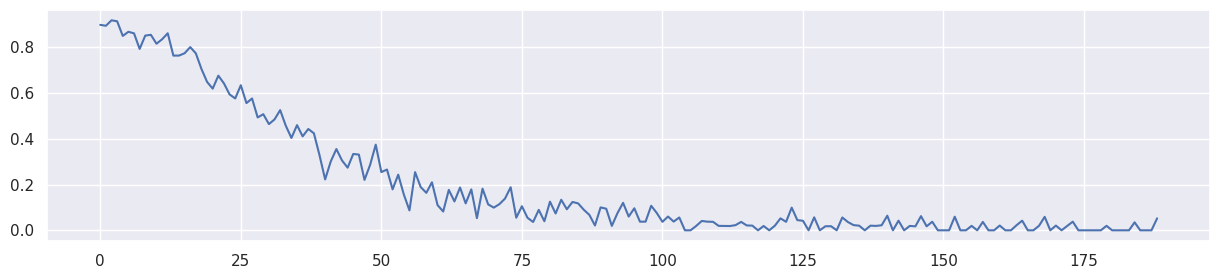

Mean F1 for all data: 0.19795393737648215
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 121.858131] [G loss: 0.639732]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 172.853302] [G loss: 0.523426]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 216.578873] [G loss: 0.435627]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 219.665833] [G loss: 0.395295]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 177.239059] [G loss: 0.362691]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 140.539719] [G loss: 0.333479]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 99.540207] [G loss: 0.299867]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 83.440376] [G loss: 0.268683]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 77.581650] [G loss: 0.250648]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 71.249878] [G loss: 0.240346]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 64.647469] [G loss: 0.234575]
[Lambda: 0.300000] [Epoch 2400/4000

100%|██████████| 189/189 [00:00<00:00, 509.12it/s]


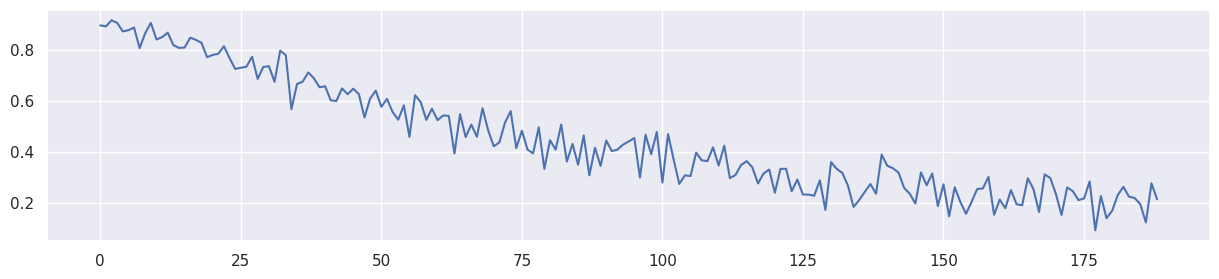

Mean F1 for all data: 0.4487118442249922
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 111.426186] [G loss: 0.640696]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 168.006500] [G loss: 0.521206]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 203.133652] [G loss: 0.435513]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 190.098175] [G loss: 0.393500]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 153.851700] [G loss: 0.359882]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 114.062393] [G loss: 0.329358]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 82.013313] [G loss: 0.293851]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 70.637260] [G loss: 0.265000]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 64.129822] [G loss: 0.248783]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 58.732170] [G loss: 0.239865]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 53.560486] [G loss: 0.234487]
[Lambda: 0.400000] [Epoch 2400/4000]

100%|██████████| 189/189 [00:00<00:00, 523.48it/s]


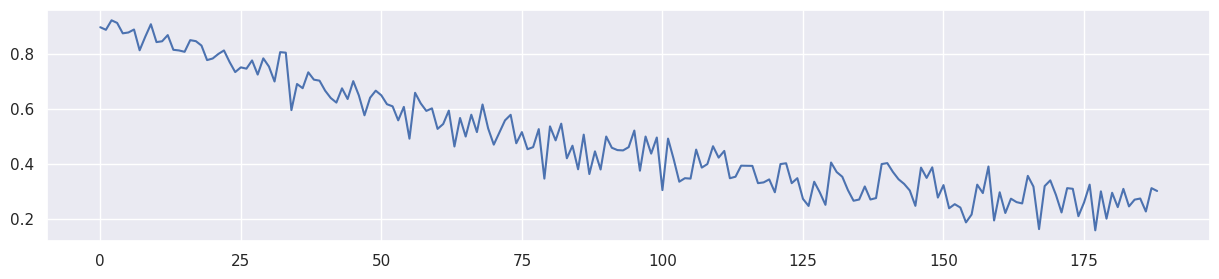

Mean F1 for all data: 0.48742130779742665
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 95.357796] [G loss: 0.646381]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 149.844986] [G loss: 0.524621]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 182.836243] [G loss: 0.435657]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 161.247757] [G loss: 0.389916]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 126.703308] [G loss: 0.353903]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 88.559830] [G loss: 0.319267]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 67.603416] [G loss: 0.282752]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 59.880104] [G loss: 0.259276]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 53.509369] [G loss: 0.246934]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 48.152111] [G loss: 0.239578]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 43.679039] [G loss: 0.233846]
[Lambda: 0.500000] [Epoch 2400/4000] 

100%|██████████| 189/189 [00:00<00:00, 530.48it/s]


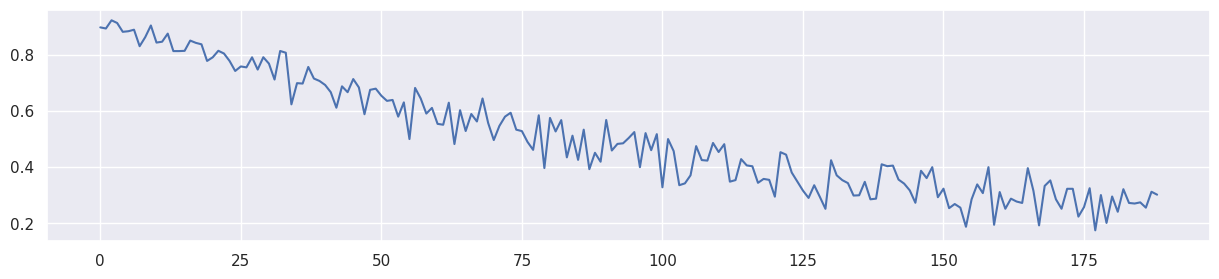

Mean F1 for all data: 0.5039110400178235
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 1.405430] [G loss: 0.673815]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 80.082954] [G loss: 0.580669]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 121.790413] [G loss: 0.467498]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 117.842476] [G loss: 0.394673]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 99.151672] [G loss: 0.342770]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 84.348396] [G loss: 0.299773]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 73.342751] [G loss: 0.271685]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 63.712837] [G loss: 0.255111]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 55.916245] [G loss: 0.245019]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 49.964920] [G loss: 0.238372]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 46.002838] [G loss: 0.233284]
[Lambda: 0.600000] [Epoch 2400/4000] [mi 

100%|██████████| 189/189 [00:00<00:00, 521.62it/s]


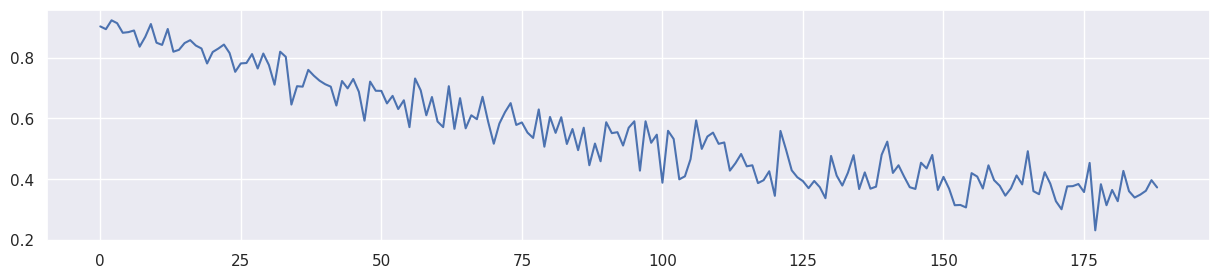

Mean F1 for all data: 0.5573695338215795
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 0.777711] [G loss: 0.674546]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 40.597435] [G loss: 0.600855]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 97.934219] [G loss: 0.474563]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 94.838280] [G loss: 0.394721]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 77.337868] [G loss: 0.339417]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 66.815422] [G loss: 0.297068]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 57.929688] [G loss: 0.269891]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 50.868252] [G loss: 0.253968]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 45.749729] [G loss: 0.243913]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 42.035950] [G loss: 0.237339]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 39.556709] [G loss: 0.232427]
[Lambda: 0.700000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 515.84it/s]


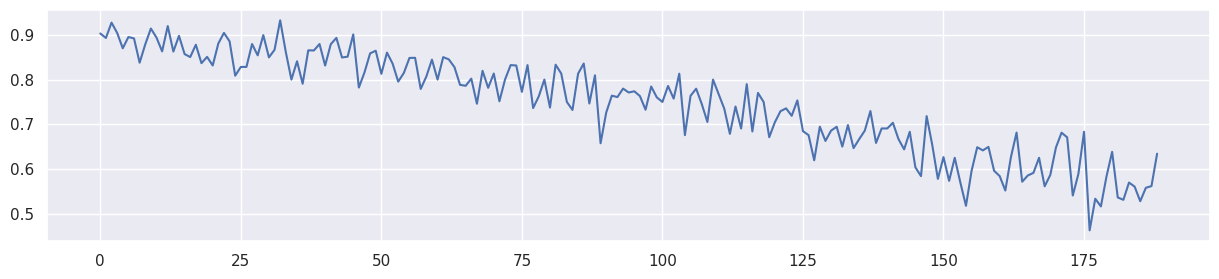

Mean F1 for all data: 0.7464347752027538
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 0.322217] [G loss: 0.675282]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 14.438745] [G loss: 0.625845]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 64.835861] [G loss: 0.492642]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 65.468094] [G loss: 0.399892]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 58.697365] [G loss: 0.337932]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 50.337509] [G loss: 0.296557]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 44.415100] [G loss: 0.270762]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 40.406876] [G loss: 0.255345]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 37.561096] [G loss: 0.245532]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 35.531086] [G loss: 0.238754]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 34.185303] [G loss: 0.233799]
[Lambda: 0.800000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 482.44it/s]


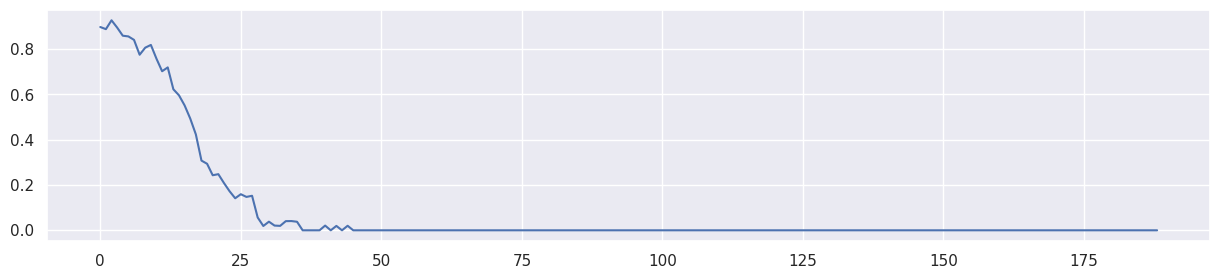

Mean F1 for all data: 0.08376696772359606
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 89.152664] [G loss: 0.687443]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 0.132350] [G loss: 0.675668]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 1.136044] [G loss: 0.646215]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 16.646324] [G loss: 0.546899]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 33.582680] [G loss: 0.419377]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 35.837280] [G loss: 0.344489]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 34.469028] [G loss: 0.300286]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 32.688580] [G loss: 0.273905]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 31.453552] [G loss: 0.258099]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 30.660173] [G loss: 0.247663]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 30.036827] [G loss: 0.240280]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 29.723646] [G loss: 0.234937]
[Lambda: 0.900000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 512.78it/s]


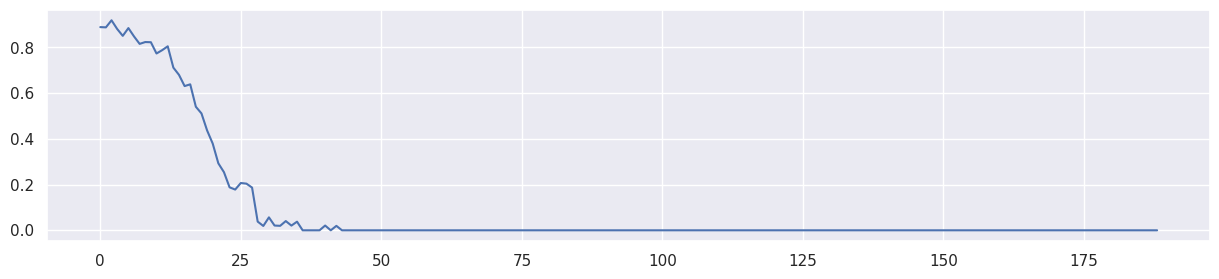

Mean F1 for all data: 0.09164855661054552


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.883721  0.718557  0.651163  0.245552
2        0.2  0.868571  0.879630  0.721634  0.657407  0.245552
3        0.3  0.868571  0.895928  0.726968  0.663594  0.245552
4        0.4  0.875000  0.895928  0.731976  0.663594  0.243805
5        0.5  0.870056  0.900901  0.742371  0.663551  0.228285
6        0.6  0.868571  0.906667  0.752758  0.688073  0.230407
7        0.7  0.822222  0.877828  0.831724  0.842975  0.130351
8        0.8  0.551020  0.600000  0.537934  0.572816  0.118774
9        0.9  0.335135  0.310881  0.447334  0.526829  0.369255
0        0.0  0.858757  0.894977  0.549865  0.384615  0.278514
1        0.1  0.871508  0.895928  0.493614  0.271429  0.263833
2        0.2  0.860465  0.897196  0.197954  0.052174  0.249203
3        0.3  0.853801  0.897196  0.448712  0.213740  0.244493
4        0.4  0.867052  0.897196  0.487421  0.302158  0.260248
5        0.5  0.872093  0.897196  0.503911  0.302158  0.262847
6        0.6  0.855491  0.902326  0.557370  0.373333  0.242091
7        0.7  0.873563  0.903226  0.746435  0.634146  0.242351
8        0.8  0.865497  0.897196  0.083767  0.000000  0.248901
9        0.9  0.870588  0.888889  0.091649  0.000000  0.223450

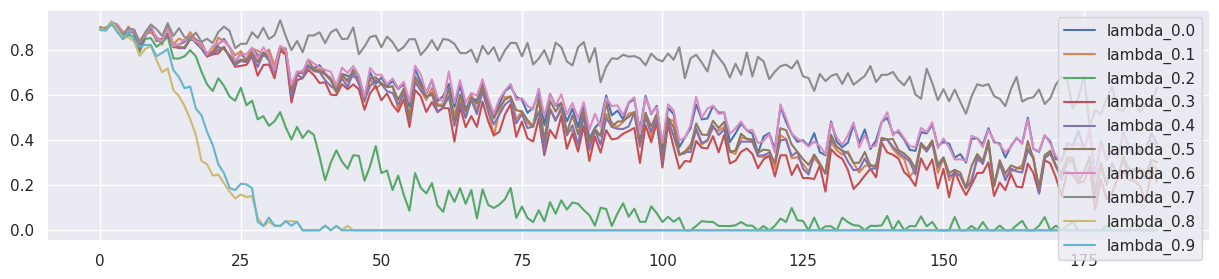

In [148]:
seed_everything()

train_result = []

avaible_range = 1

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.3]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    '''
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
    '''
    f1,mi,last_generator, last_adapter = train_model5(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.00015) #0.000153)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,last_adapter,2000)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



+ bucket number를 normalize하면 모델의 유효기간을 설정할 수 있다.
+ 즉, 유효기간까지는 model의 성능을 보전 시킬 수 있는 개념
+ 상기 모든 처리를 그대로 두고 bucket number를 normalize 하여 실험 한다.

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 136.300049] [G loss: 0.641753]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 188.251282] [G loss: 0.546021]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 214.842316] [G loss: 0.441682]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 255.102875] [G loss: 0.402107]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 254.924118] [G loss: 0.378704]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 221.393982] [G loss: 0.348393]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 189.266907] [G loss: 0.320939]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 149.335342] [G loss: 0.289354]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 153.561264] [G loss: 0.264815]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 169.104889] [G loss: 0.251440]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 184.853577] [G loss: 0.242782]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 197.627258] [G loss: 0.2

100%|██████████| 189/189 [00:00<00:00, 516.02it/s]


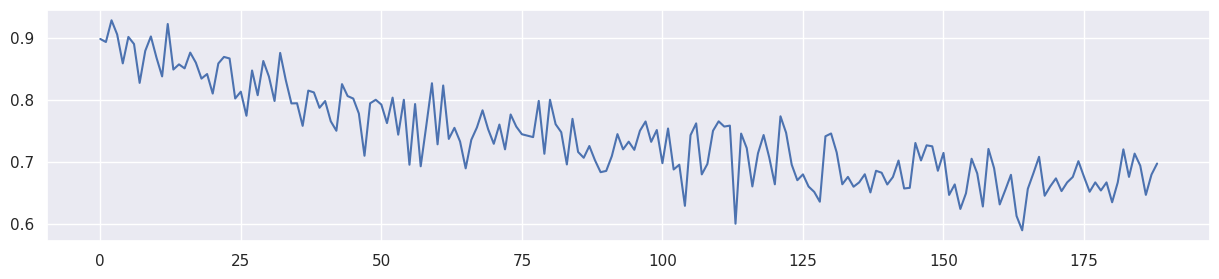

Mean F1 for all data: 0.7404989418566827
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 134.600143] [G loss: 0.641765]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 186.253052] [G loss: 0.545518]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 210.944809] [G loss: 0.441355]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 237.752884] [G loss: 0.401625]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 221.537079] [G loss: 0.376995]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 186.792465] [G loss: 0.346201]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 155.097366] [G loss: 0.318177]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 122.541603] [G loss: 0.286369]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 119.390312] [G loss: 0.264073]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 118.524216] [G loss: 0.251082]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 117.821632] [G loss: 0.242680]
[Lambda: 0.100000] [Epoch 2400

100%|██████████| 189/189 [00:00<00:00, 511.12it/s]


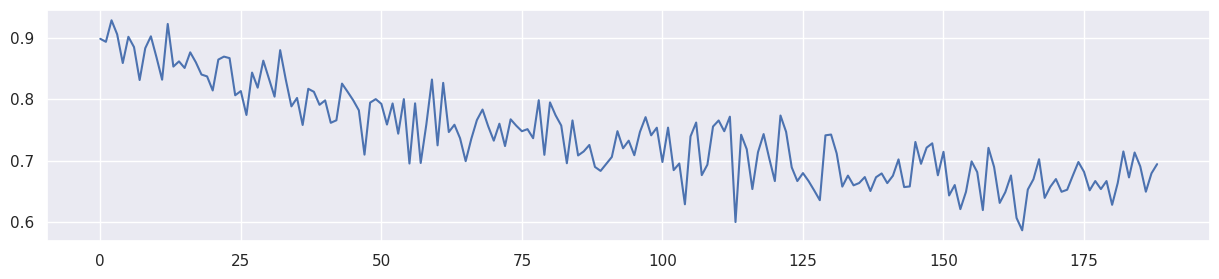

Mean F1 for all data: 0.7400851436456168
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 129.147461] [G loss: 0.642712]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 180.690521] [G loss: 0.542233]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 204.884354] [G loss: 0.437110]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 219.011368] [G loss: 0.399895]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 191.139618] [G loss: 0.375097]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 154.408020] [G loss: 0.343583]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 121.414604] [G loss: 0.314558]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 98.899017] [G loss: 0.283367]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 91.736580] [G loss: 0.262463]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 87.691841] [G loss: 0.249792]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 81.701424] [G loss: 0.241254]
[Lambda: 0.200000] [Epoch 2400/400

100%|██████████| 189/189 [00:00<00:00, 513.79it/s]


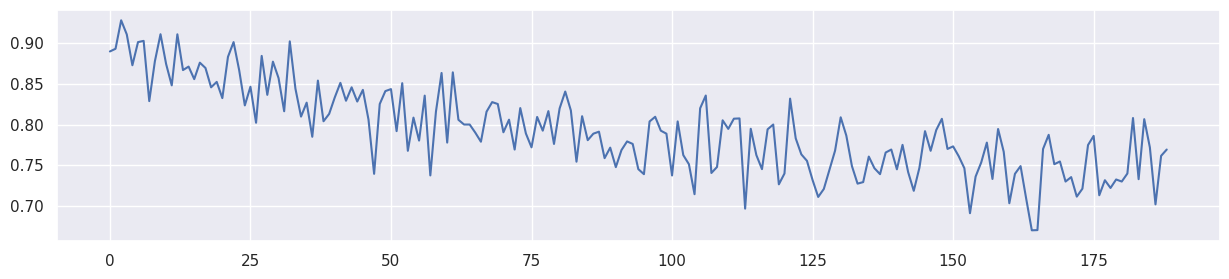

Mean F1 for all data: 0.7923255411165072
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 115.009117] [G loss: 0.646592]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 169.862793] [G loss: 0.543879]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 193.305450] [G loss: 0.438127]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 196.713333] [G loss: 0.399301]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 163.436722] [G loss: 0.372661]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 130.166534] [G loss: 0.340691]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 101.704750] [G loss: 0.309632]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 83.536644] [G loss: 0.278815]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 75.694740] [G loss: 0.259721]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 67.421219] [G loss: 0.246616]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 65.044113] [G loss: 0.238345]
[Lambda: 0.300000] [Epoch 2400/400

100%|██████████| 189/189 [00:00<00:00, 526.44it/s]


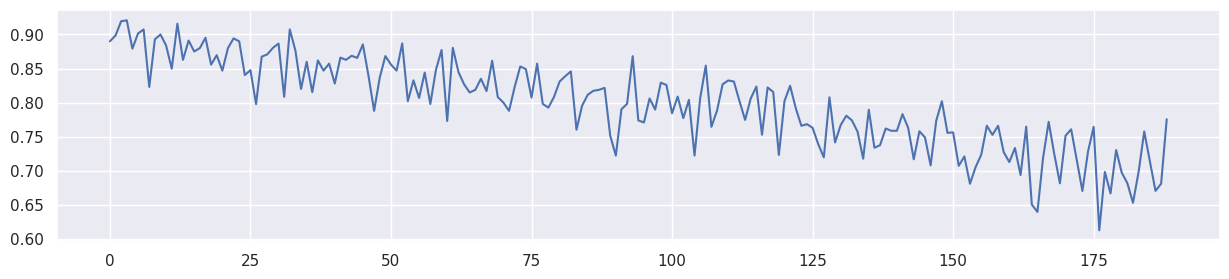

Mean F1 for all data: 0.7984525666200754
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 101.771461] [G loss: 0.648996]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 149.454880] [G loss: 0.543335]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 177.577286] [G loss: 0.435808]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 176.583511] [G loss: 0.397360]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 142.474228] [G loss: 0.368350]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 113.258202] [G loss: 0.335731]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 89.501411] [G loss: 0.304138]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 76.176025] [G loss: 0.274902]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 65.845085] [G loss: 0.255452]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 60.021950] [G loss: 0.244467]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 54.545086] [G loss: 0.236988]
[Lambda: 0.400000] [Epoch 2400/4000

100%|██████████| 189/189 [00:00<00:00, 528.27it/s]


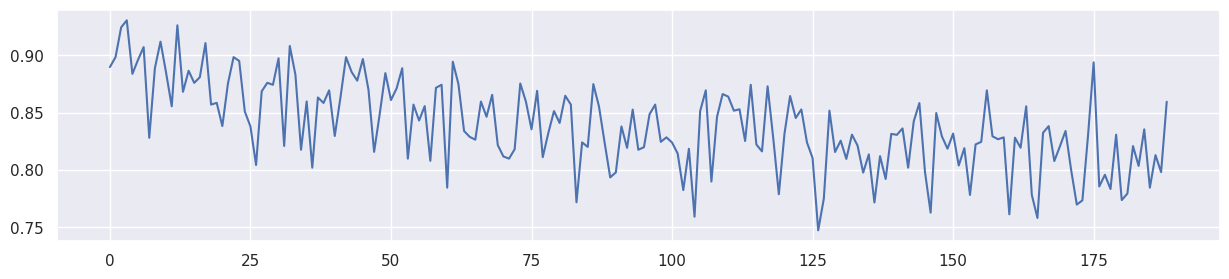

Mean F1 for all data: 0.8386097823509214
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 96.166519] [G loss: 0.650447]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 139.715836] [G loss: 0.545293]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 162.737747] [G loss: 0.436339]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 147.463440] [G loss: 0.397006]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 113.819923] [G loss: 0.363035]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 88.210686] [G loss: 0.327537]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 68.700821] [G loss: 0.292644]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 56.418282] [G loss: 0.264375]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 52.287334] [G loss: 0.248549]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 47.889988] [G loss: 0.239786]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 43.441147] [G loss: 0.234121]
[Lambda: 0.500000] [Epoch 2400/4000] 

100%|██████████| 189/189 [00:00<00:00, 491.84it/s]


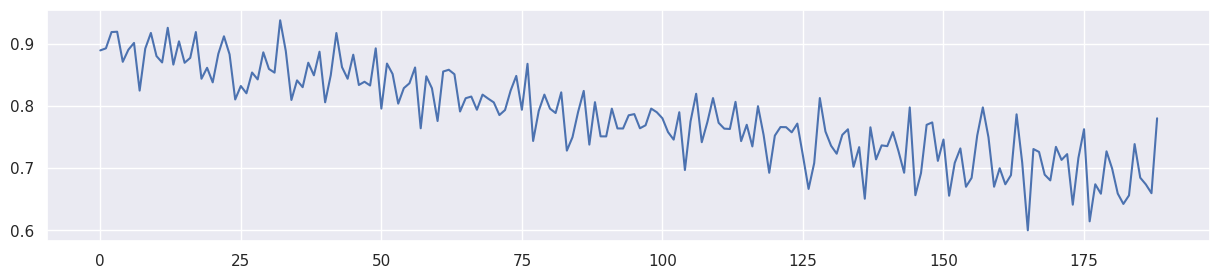

Mean F1 for all data: 0.7847817759409276
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 92.417160] [G loss: 0.651363]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 129.712479] [G loss: 0.547791]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 148.317551] [G loss: 0.438198]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 128.824570] [G loss: 0.395525]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 97.229309] [G loss: 0.360179]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 75.568489] [G loss: 0.324629]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 55.314396] [G loss: 0.289954]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 47.640053] [G loss: 0.262668]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 43.837204] [G loss: 0.248094]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 40.113514] [G loss: 0.239567]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 37.689037] [G loss: 0.233636]
[Lambda: 0.600000] [Epoch 2400/4000] [

100%|██████████| 189/189 [00:00<00:00, 528.74it/s]


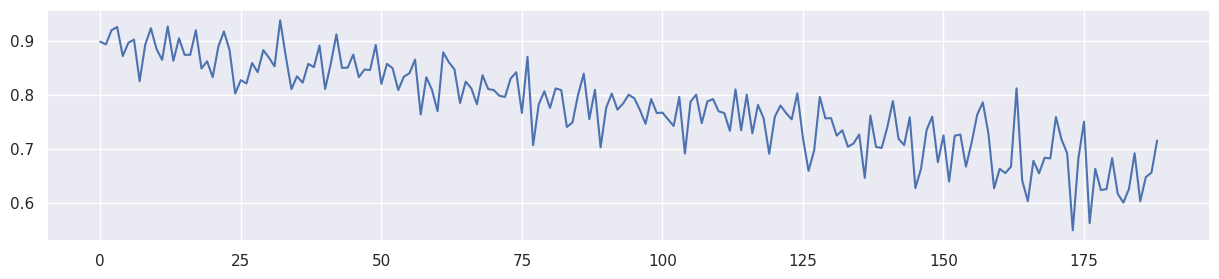

Mean F1 for all data: 0.7773122063541941
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 86.432831] [G loss: 0.654072]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 110.461380] [G loss: 0.558806]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 125.818756] [G loss: 0.441991]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 108.319939] [G loss: 0.393955]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 82.578842] [G loss: 0.357349]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 63.269943] [G loss: 0.322975]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 47.868671] [G loss: 0.288726]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 42.076412] [G loss: 0.262601]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 38.892963] [G loss: 0.247969]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 36.582561] [G loss: 0.238067]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 35.259384] [G loss: 0.230560]
[Lambda: 0.700000] [Epoch 2400/4000] [

100%|██████████| 189/189 [00:00<00:00, 527.81it/s]


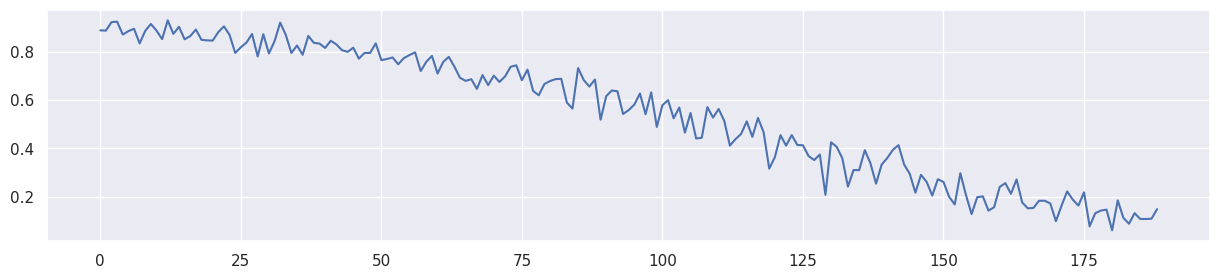

Mean F1 for all data: 0.5468854974847221
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 73.701553] [G loss: 0.663924]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 58.946072] [G loss: 0.601296]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 52.557247] [G loss: 0.470990]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 56.952137] [G loss: 0.378223]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 51.371597] [G loss: 0.324757]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 45.792274] [G loss: 0.289654]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 41.346996] [G loss: 0.266590]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 37.784588] [G loss: 0.250975]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 35.332569] [G loss: 0.240866]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 33.839046] [G loss: 0.234526]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 32.902016] [G loss: 0.230333]
[Lambda: 0.800000] [Epoch 2400/4000] [mi 

100%|██████████| 189/189 [00:00<00:00, 518.71it/s]


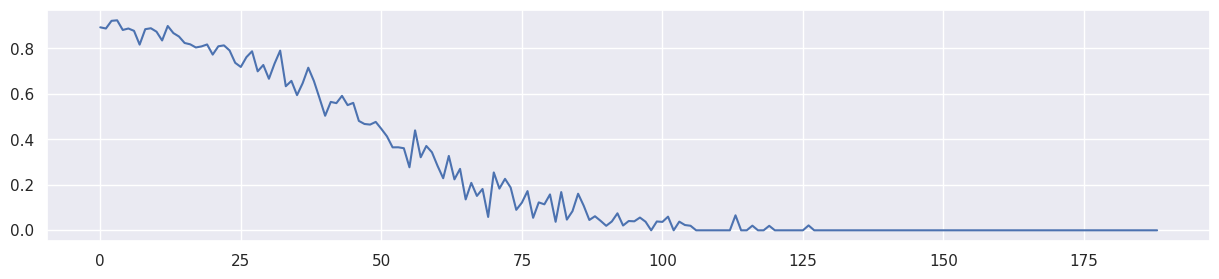

Mean F1 for all data: 0.2416496224173674
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 100.029007] [G loss: 0.686119]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 39.490662] [G loss: 0.677135]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 30.691410] [G loss: 0.650238]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 29.528477] [G loss: 0.624120]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 25.686039] [G loss: 0.561237]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 40.808125] [G loss: 0.401314]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 40.661697] [G loss: 0.317957]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 37.167168] [G loss: 0.282755]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 34.414913] [G loss: 0.264123]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 32.570065] [G loss: 0.252912]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 31.322691] [G loss: 0.245560]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 30.525208] [G loss: 0.240323]
[Lambda: 0.900000] [Epoch 2400/4000] [mi 

100%|██████████| 189/189 [00:00<00:00, 534.27it/s]


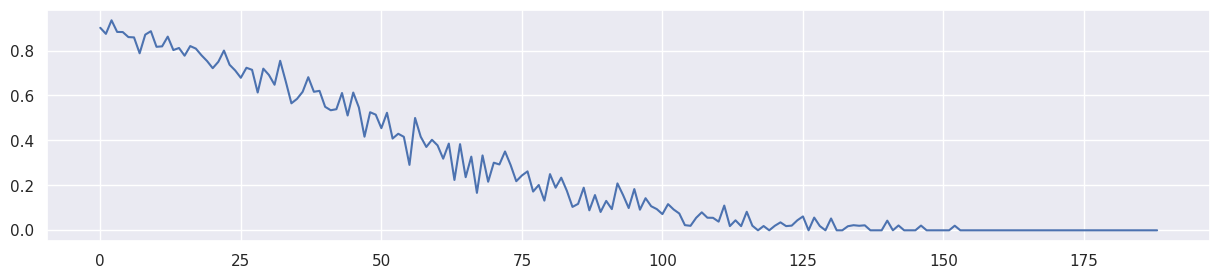

Mean F1 for all data: 0.2636331856896167


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.883721  0.718557  0.651163  0.245552
2        0.2  0.868571  0.879630  0.721634  0.657407  0.245552
3        0.3  0.868571  0.895928  0.726968  0.663594  0.245552
4        0.4  0.875000  0.895928  0.731976  0.663594  0.243805
5        0.5  0.870056  0.900901  0.742371  0.663551  0.228285
6        0.6  0.868571  0.906667  0.752758  0.688073  0.230407
7        0.7  0.822222  0.877828  0.831724  0.842975  0.130351
8        0.8  0.551020  0.600000  0.537934  0.572816  0.118774
9        0.9  0.335135  0.310881  0.447334  0.526829  0.369255
0        0.0  0.845714  0.898148  0.740499  0.697095  0.251304
1        0.1  0.845714  0.898148  0.740085  0.694215  0.251304
2        0.2  0.857143  0.889908  0.792326  0.769231  0.236102
3        0.3  0.865169  0.889908  0.798453  0.775510  0.265881
4        0.4  0.865169  0.889908  0.838610  0.859649  0.265881
5        0.5  0.873563  0.889908  0.784782  0.780488  0.241260
6        0.6  0.878613  0.898148  0.777312  0.715026  0.239041
7        0.7  0.878613  0.888889  0.546885  0.148760  0.256903
8        0.8  0.870588  0.893023  0.241650  0.000000  0.245861
9        0.9  0.841463  0.901408  0.263633  0.000000  0.219054

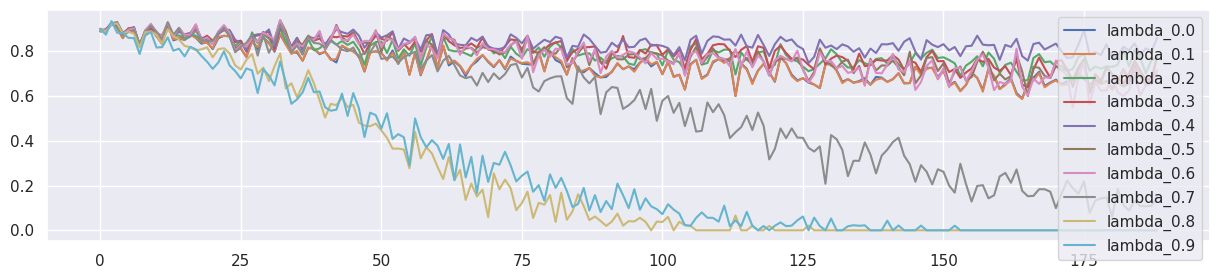

In [147]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    '''
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
    '''
    f1,mi,last_generator, last_adapter = train_model5(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.00015)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,last_adapter,2000)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



+ lambda 0.4 에서, I(z,b)와 I(g,b)를 비교하기

In [51]:
def test_all_data5(generator,adapter,train_size):

    XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    gs = torch.tensor([])
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            xs = adapter(tmp_x[:,4].reshape(-1,1),tmp_x[:,5].reshape(-1,1)/avaible_range).reshape(-1,1)
            gs = torch.cat((gs,xs),0)
            predicted_y = generator(torch.cat((tmp_x[:,0:4],xs),1))
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s,gs

[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 93.923409] [G loss: 0.669354]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 139.335175] [G loss: 0.605831]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 164.897507] [G loss: 0.528624]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 144.504639] [G loss: 0.484545]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 125.544777] [G loss: 0.441000]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 107.904396] [G loss: 0.396791]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 93.798691] [G loss: 0.352507]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 84.841049] [G loss: 0.311347]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 79.082924] [G loss: 0.278739]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 75.411499] [G loss: 0.255975]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 73.061630] [G loss: 0.242010]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: 71.388351] [G loss: 0.234137]
[

100%|██████████| 190/190 [00:00<00:00, 532.57it/s]


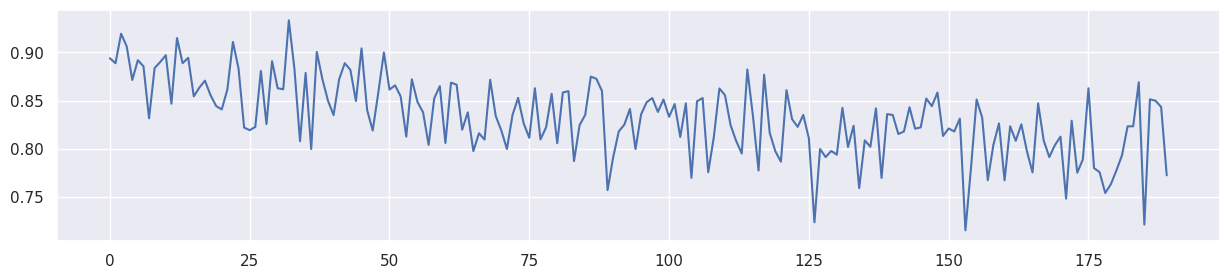

Mean F1 for all data: 0.8332689779434483
gs.shape torch.Size([38000, 1])
I(z,b) b     5.932748
z0    0.140249
x1    0.000640
x0    0.000000
x2    0.000000
x3    0.000000
Name: MI Scores, dtype: float64
I(g,b) 0.39605497515865284


In [52]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.7]

#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    '''
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
    '''
    f1,mi,last_generator, last_adapter = train_model5(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.000153)
    result_table[f'lambda_{lambda_f}'],gs = test_all_data5(last_generator,last_adapter,2000)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

print('gs.shape',gs.shape)
mi_scores = make_mi_scores(X[2000:], X[2000:]['b'], discrete_features="auto")
print('I(z,b)',mi_scores)
mi_scores = make_mi_scores(pd.DataFrame(gs.data.numpy(),columns=['g']), X[2000:]['b'], discrete_features="auto")
print('I(g,b)',mi_scores['g'])



# D(x,G(z,b)) + MINE 구조

+ D(x,G(z,b)) 구조에서 보면, I(z,y), I(g,y) 를 최대로 만들때 성능이 향상됨을 확인 함.
+ 이는 I(z,y^)을 최소화 해서 over-fitting 을 막는 것이 아닌, b와의 관계성을 더 증폭시켜서 b에 적응한 학습을 하게하는 효과라고 해석함.
+ 따라서, 학습 알고리즘 상에서 I(z,y) 또는 I(g,y) 를 최대로

In [53]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model55(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter()
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net()
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  MINE -> I(Z,B)의 측정
        # -------------------------------
        '''
        s = np.random.choice(XS_train.shape[0],minibatch)

        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = XS_train[s][:,5].reshape(-1,1) # bucket number.. B
        y_shuffle = XS_train[np.random.permutation(s)][:,5].reshape(-1,1) #permute bucket number.. B
        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = - ret1

        ibz = torch.full((XS_train.shape[0],1), ret1.data.numpy())
        '''
        a_z = adapter(XS_train[:,4].reshape(-1,1) ,XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = mse_loss(a_z, XS_train[:,5].reshape(-1,1)) 

        # -------------------
        #  Forwards Generator
        # -------------------
        xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  I(g,y)의 MINE loss
        # -------------------------------
        
        s = np.random.choice(XS_train.shape[0],minibatch)

        #x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        x_sample = a_z[s] #Variable(torch.from_numpy(a_z[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        #y_sample = gen_y[s]
        #y_shuffle = gen_y[np.random.permutation(s)]
        y_sample = y_train[s].reshape(-1,1)
        y_shuffle = y_train[np.random.permutation(s)].reshape(-1,1)
        #y_sample = XS_train[s,5].reshape(-1,1)
        #y_shuffle = XS_train[np.random.permutation(s),5].reshape(-1,1)
        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = - ret1

        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha + mi_loss * lambda_a2 #* 0.05

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model2(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator,adapter

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 108.243347] [G loss: 0.663266]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 231.869751] [G loss: 0.572151]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 270.671692] [G loss: 0.512675]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 316.367767] [G loss: 0.471911]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 347.042694] [G loss: 0.436826]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 344.690948] [G loss: 0.405464]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 320.246765] [G loss: 0.375531]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 286.860138] [G loss: 0.345147]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 220.707031] [G loss: 0.316459]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 198.018829] [G loss: 0.291457]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 178.210129] [G loss: 0.271791]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 166.654999] [G loss: 0.25

100%|██████████| 189/189 [00:00<00:00, 530.86it/s]


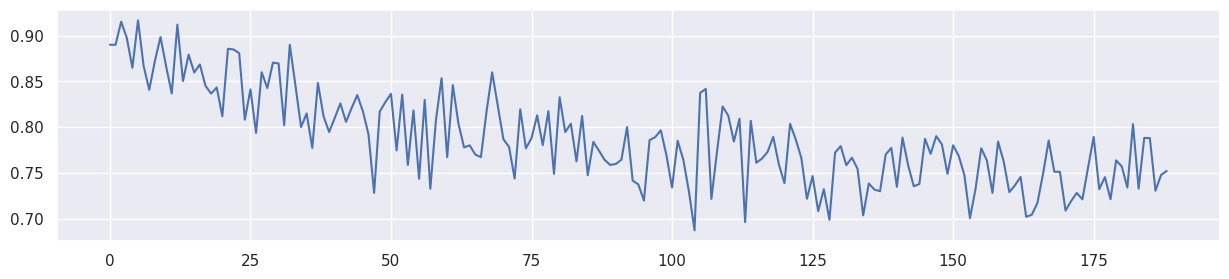

Mean F1 for all data: 0.787364580387837
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 105.813568] [G loss: 0.663549]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 224.925415] [G loss: 0.571840]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 261.482086] [G loss: 0.512677]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 286.929016] [G loss: 0.472420]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 295.413910] [G loss: 0.436675]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 283.168030] [G loss: 0.398050]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 237.539017] [G loss: 0.348943]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 178.443939] [G loss: 0.316404]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 142.538040] [G loss: 0.290003]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 128.179382] [G loss: 0.270274]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 110.996780] [G loss: 0.255141]
[Lambda: 0.100000] [Epoch 2400/4

100%|██████████| 189/189 [00:00<00:00, 511.13it/s]


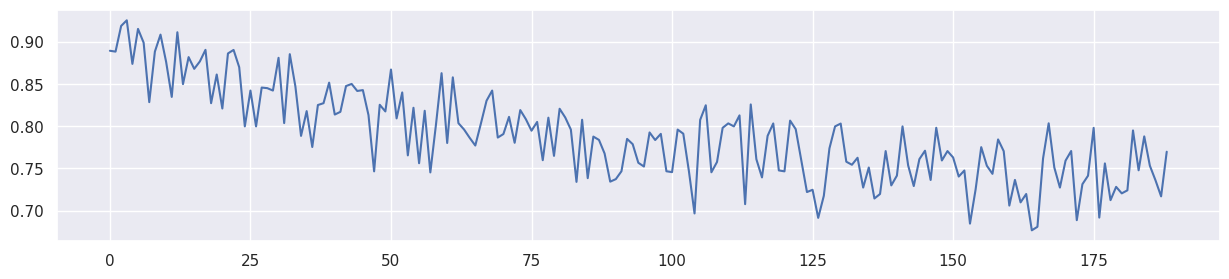

Mean F1 for all data: 0.7893671169474091
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 103.205147] [G loss: 0.664027]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 217.686035] [G loss: 0.572566]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 245.283508] [G loss: 0.513014]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 256.796722] [G loss: 0.473019]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 248.298691] [G loss: 0.436852]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 225.286148] [G loss: 0.402541]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 196.167007] [G loss: 0.369716]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 161.255188] [G loss: 0.337901]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 139.513763] [G loss: 0.308062]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 122.879272] [G loss: 0.283954]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 111.143059] [G loss: 0.265246]
[Lambda: 0.200000] [Epoch 2400/

100%|██████████| 189/189 [00:00<00:00, 516.60it/s]


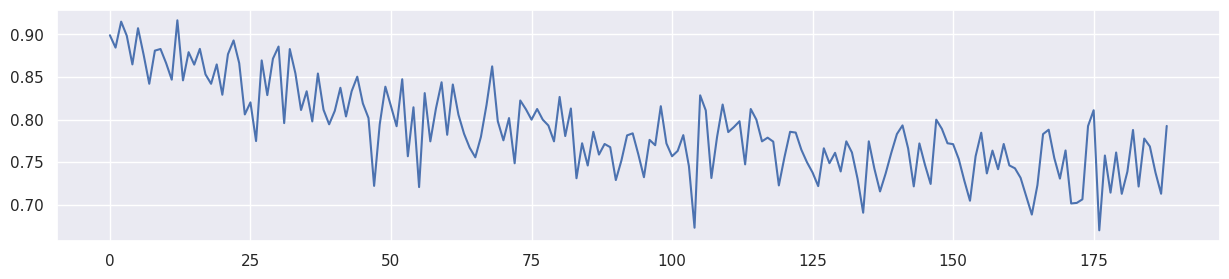

Mean F1 for all data: 0.7880863336893624
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 101.687775] [G loss: 0.664638]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 208.781021] [G loss: 0.573662]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 232.330887] [G loss: 0.513584]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 232.175491] [G loss: 0.473921]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 215.080307] [G loss: 0.437627]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 196.021774] [G loss: 0.402058]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 165.155258] [G loss: 0.368621]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 141.409378] [G loss: 0.335967]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 121.609917] [G loss: 0.306510]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 110.083359] [G loss: 0.281884]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 101.273384] [G loss: 0.263819]
[Lambda: 0.300000] [Epoch 2400/

100%|██████████| 189/189 [00:00<00:00, 503.44it/s]


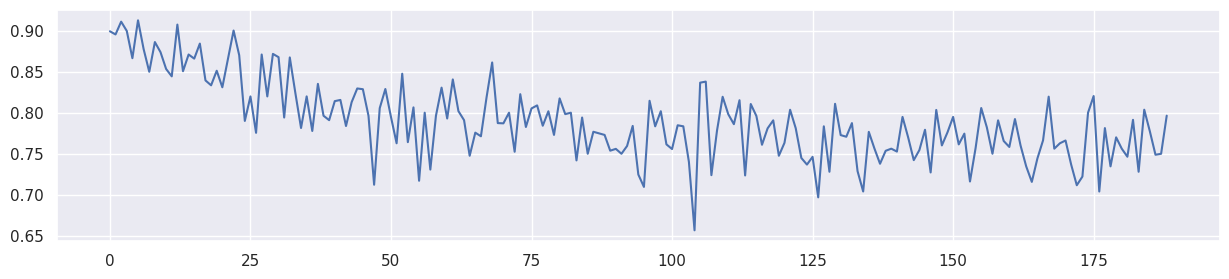

Mean F1 for all data: 0.7900853831680527
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 99.925819] [G loss: 0.665471]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 197.100082] [G loss: 0.575992]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 214.460342] [G loss: 0.514754]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 207.158691] [G loss: 0.475240]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 187.673920] [G loss: 0.439261]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 162.253159] [G loss: 0.403391]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 136.926651] [G loss: 0.368125]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 119.431007] [G loss: 0.334946]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 100.063004] [G loss: 0.304866]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 83.804352] [G loss: 0.277132]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 75.081161] [G loss: 0.254911]
[Lambda: 0.400000] [Epoch 2400/400

100%|██████████| 189/189 [00:00<00:00, 515.35it/s]


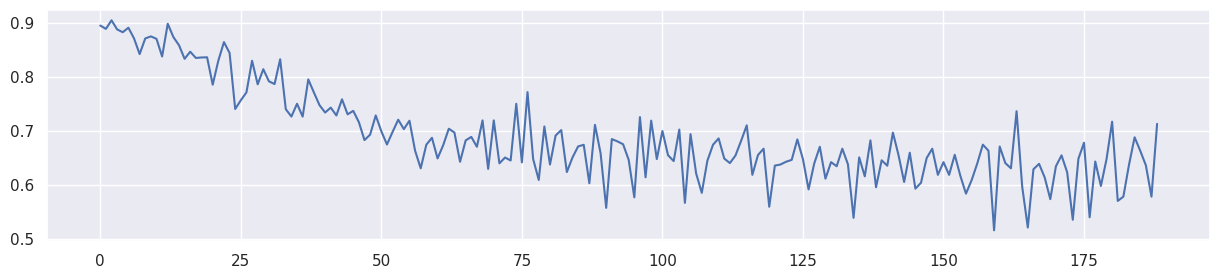

Mean F1 for all data: 0.6896966687814418
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 97.844063] [G loss: 0.666519]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 181.979233] [G loss: 0.579143]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 200.110657] [G loss: 0.516258]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 187.467743] [G loss: 0.477217]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 166.852493] [G loss: 0.439348]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 145.990341] [G loss: 0.401602]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 127.360107] [G loss: 0.365655]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 108.387817] [G loss: 0.332261]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 93.789894] [G loss: 0.300877]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 83.620262] [G loss: 0.274689]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 78.096909] [G loss: 0.256356]
[Lambda: 0.500000] [Epoch 2400/4000

100%|██████████| 189/189 [00:00<00:00, 528.11it/s]


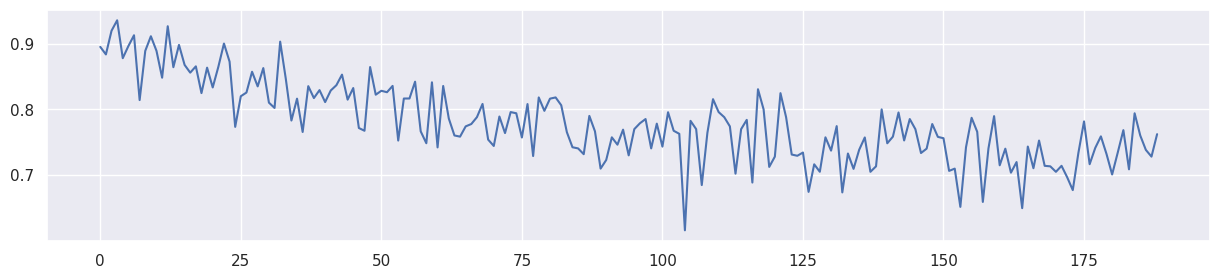

Mean F1 for all data: 0.7796502149006402
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 95.786987] [G loss: 0.667946]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 160.930450] [G loss: 0.591422]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 182.366425] [G loss: 0.520463]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 164.367554] [G loss: 0.480419]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 143.141174] [G loss: 0.441879]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 123.961273] [G loss: 0.401650]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 106.118736] [G loss: 0.361909]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 91.973869] [G loss: 0.323865]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 83.111832] [G loss: 0.289864]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 77.704330] [G loss: 0.265307]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 74.082047] [G loss: 0.247978]
[Lambda: 0.600000] [Epoch 2400/4000]

100%|██████████| 189/189 [00:00<00:00, 518.20it/s]


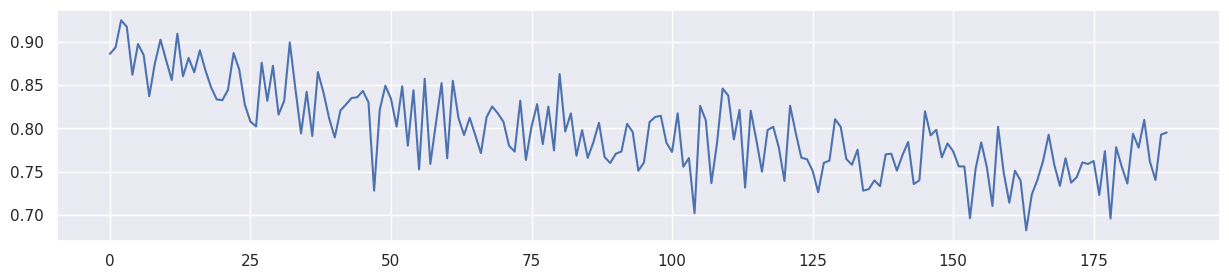

Mean F1 for all data: 0.7969736459884948
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 94.265297] [G loss: 0.669189]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 139.129425] [G loss: 0.605852]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 165.083328] [G loss: 0.528453]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 144.397247] [G loss: 0.484525]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 125.479912] [G loss: 0.440983]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 107.827827] [G loss: 0.396778]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 93.796692] [G loss: 0.352469]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 84.824875] [G loss: 0.311318]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 79.063950] [G loss: 0.278720]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 75.421707] [G loss: 0.255948]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 73.070374] [G loss: 0.241983]
[Lambda: 0.700000] [Epoch 2400/4000] 

100%|██████████| 189/189 [00:00<00:00, 520.20it/s]


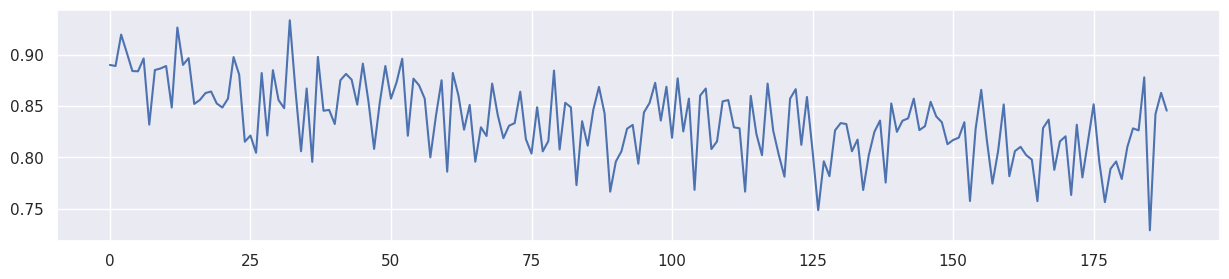

Mean F1 for all data: 0.8358467313278357
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 92.723732] [G loss: 0.670305]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 89.146683] [G loss: 0.646817]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 85.496353] [G loss: 0.616317]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 81.624825] [G loss: 0.576955]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 77.461525] [G loss: 0.526442]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 73.327538] [G loss: 0.469273]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 69.669014] [G loss: 0.416513]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 66.686424] [G loss: 0.376128]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 64.370407] [G loss: 0.350361]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 62.601711] [G loss: 0.336252]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 61.197224] [G loss: 0.329088]
[Lambda: 0.800000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 493.24it/s]


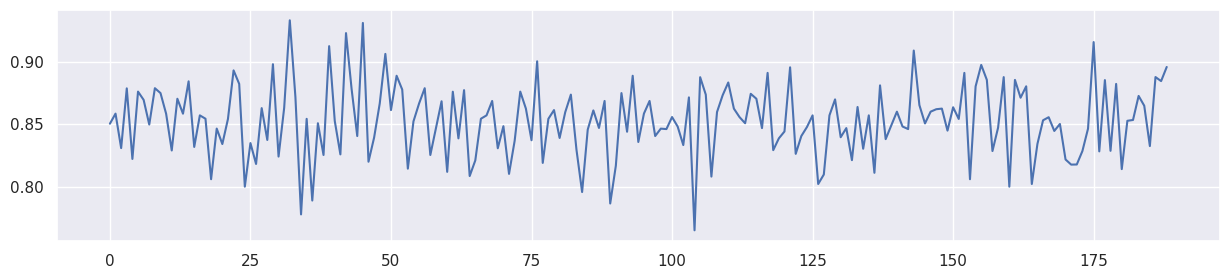

Mean F1 for all data: 0.8528047633954339
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 96.879539] [G loss: 0.687072]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 70.149391] [G loss: 0.675417]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 32.504307] [G loss: 0.643251]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 30.613380] [G loss: 0.611360]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 26.168499] [G loss: 0.541329]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 41.330616] [G loss: 0.347656]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 38.648605] [G loss: 0.289876]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 35.359680] [G loss: 0.264200]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 33.371418] [G loss: 0.249869]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 32.056347] [G loss: 0.241449]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 31.241970] [G loss: 0.235840]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 30.658319] [G loss: 0.232423]
[Lambda: 0.900000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 503.53it/s]


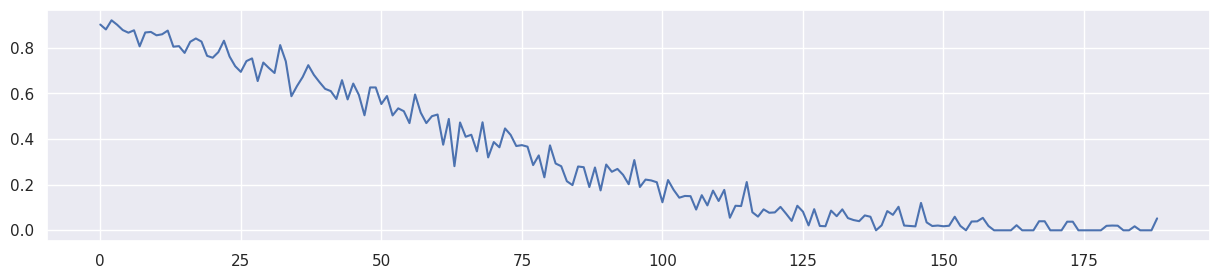

Mean F1 for all data: 0.31768487464408474


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.883721  0.718557  0.651163  0.245552
2        0.2  0.868571  0.879630  0.721634  0.657407  0.245552
3        0.3  0.868571  0.895928  0.726968  0.663594  0.245552
4        0.4  0.875000  0.895928  0.731976  0.663594  0.243805
5        0.5  0.870056  0.900901  0.742371  0.663551  0.228285
6        0.6  0.868571  0.906667  0.752758  0.688073  0.230407
7        0.7  0.822222  0.877828  0.831724  0.842975  0.130351
8        0.8  0.551020  0.600000  0.537934  0.572816  0.118774
9        0.9  0.335135  0.310881  0.447334  0.526829  0.369255
0        0.0  0.881356  0.889908  0.787365  0.752066  0.257950
1        0.1  0.857143  0.889908  0.789367  0.769874  0.249627
2        0.2  0.870056  0.899083  0.788086  0.792627  0.251423
3        0.3  0.875000  0.899083  0.790085  0.796380  0.255258
4        0.4  0.880000  0.894977  0.689697  0.712766  0.231494
5        0.5  0.868571  0.894977  0.779650  0.762376  0.242177
6        0.6  0.863636  0.885845  0.796974  0.795181  0.222797
7        0.7  0.880000  0.889908  0.835847  0.845455  0.236485
8        0.8  0.786127  0.850467  0.852805  0.895928  0.100520
9        0.9  0.855422  0.901408  0.317685  0.052174  0.230692

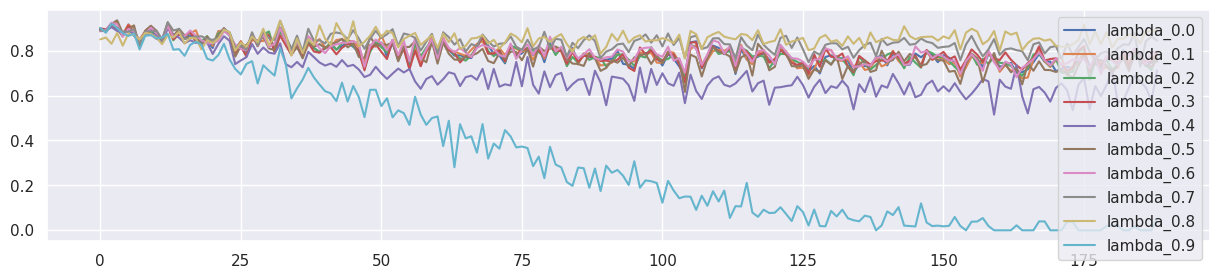

In [54]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.7]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.


lambda_f_set2 = [0.0001478] #,0.000001,0.000002,0.000003,0.000004]
#lambda_f_set2 = [0.00503] #,0.00502,0.00503] #,0.000001,0.000002,0.000003,0.000004]
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    lambda_a2 = lambda_f2
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model55(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.000153)
        result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,last_adapter,2000)

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])


+ 유효기간을 더 연장하다.

[Lambda: 0.000000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.000000] [Epoch 200/4000] [mi loss: 108.223732] [G loss: 0.663300]
[Lambda: 0.000000] [Epoch 400/4000] [mi loss: 232.217194] [G loss: 0.572286]
[Lambda: 0.000000] [Epoch 600/4000] [mi loss: 270.647522] [G loss: 0.512803]
[Lambda: 0.000000] [Epoch 800/4000] [mi loss: 316.561584] [G loss: 0.471976]
[Lambda: 0.000000] [Epoch 1000/4000] [mi loss: 343.138428] [G loss: 0.436932]
[Lambda: 0.000000] [Epoch 1200/4000] [mi loss: 346.401672] [G loss: 0.405146]
[Lambda: 0.000000] [Epoch 1400/4000] [mi loss: 318.470428] [G loss: 0.374840]
[Lambda: 0.000000] [Epoch 1600/4000] [mi loss: 285.132294] [G loss: 0.344492]
[Lambda: 0.000000] [Epoch 1800/4000] [mi loss: 217.455383] [G loss: 0.315519]
[Lambda: 0.000000] [Epoch 2000/4000] [mi loss: 195.101349] [G loss: 0.290146]
[Lambda: 0.000000] [Epoch 2200/4000] [mi loss: 171.996613] [G loss: 0.270381]
[Lambda: 0.000000] [Epoch 2400/4000] [mi loss: 156.798401] [G loss: 0.25

100%|██████████| 189/189 [00:00<00:00, 534.47it/s]


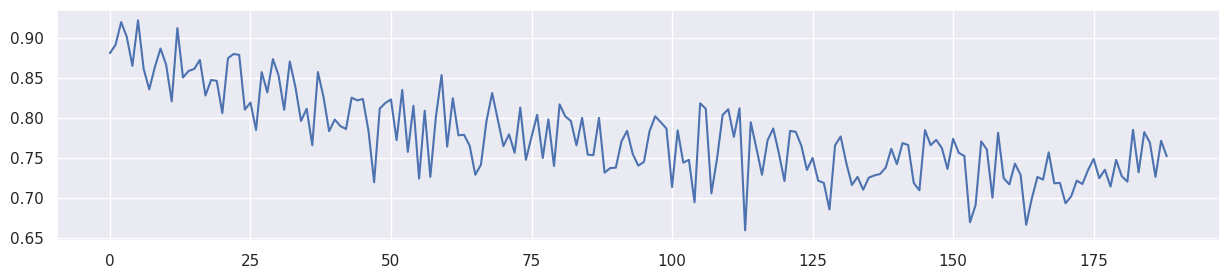

Mean F1 for all data: 0.7779682535510352
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: 105.782974] [G loss: 0.663588]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: 225.265274] [G loss: 0.571994]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: 259.615234] [G loss: 0.512829]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: 286.691711] [G loss: 0.472508]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: 294.694855] [G loss: 0.436687]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: 283.173492] [G loss: 0.381485]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: 228.349579] [G loss: 0.346206]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: 180.834564] [G loss: 0.316321]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: 145.121674] [G loss: 0.290167]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: 127.890663] [G loss: 0.271099]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: 108.279808] [G loss: 0.257112]
[Lambda: 0.100000] [Epoch 2400/

100%|██████████| 189/189 [00:00<00:00, 517.43it/s]


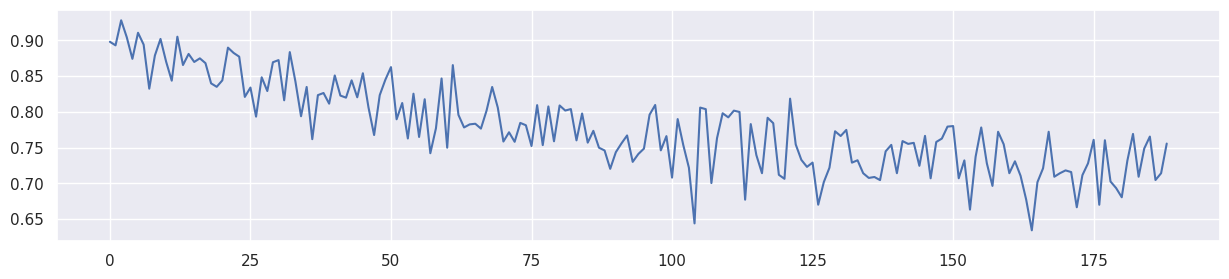

Mean F1 for all data: 0.7778330458109592
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: 103.328072] [G loss: 0.664072]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: 218.128754] [G loss: 0.572697]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: 246.397980] [G loss: 0.513137]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: 254.439133] [G loss: 0.473129]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: 247.341202] [G loss: 0.437006]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: 226.859207] [G loss: 0.402490]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: 198.505615] [G loss: 0.369643]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: 163.415558] [G loss: 0.338222]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: 139.847107] [G loss: 0.308366]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: 122.973656] [G loss: 0.284199]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: 111.066978] [G loss: 0.265354]
[Lambda: 0.200000] [Epoch 2400/

100%|██████████| 189/189 [00:00<00:00, 511.09it/s]


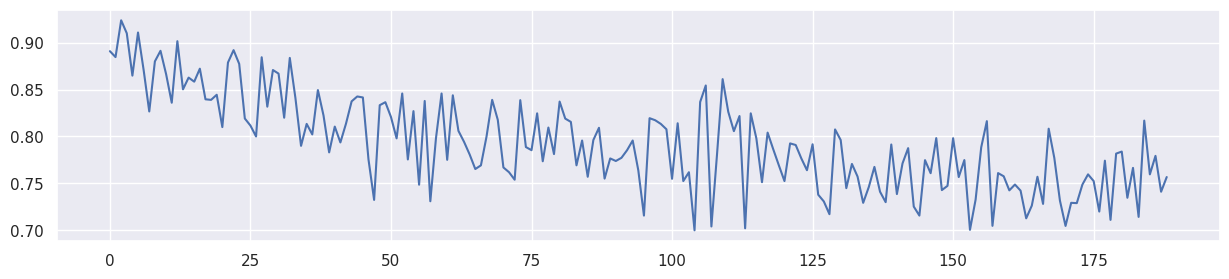

Mean F1 for all data: 0.7927712568245282
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: 101.642685] [G loss: 0.664678]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: 209.051315] [G loss: 0.573828]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: 231.915314] [G loss: 0.513762]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: 227.691666] [G loss: 0.473987]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: 216.716309] [G loss: 0.437299]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: 194.880768] [G loss: 0.401936]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: 169.242859] [G loss: 0.368436]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: 140.019257] [G loss: 0.336425]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: 121.239120] [G loss: 0.306427]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: 108.435928] [G loss: 0.281970]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: 101.019974] [G loss: 0.263915]
[Lambda: 0.300000] [Epoch 2400/

100%|██████████| 189/189 [00:00<00:00, 501.67it/s]


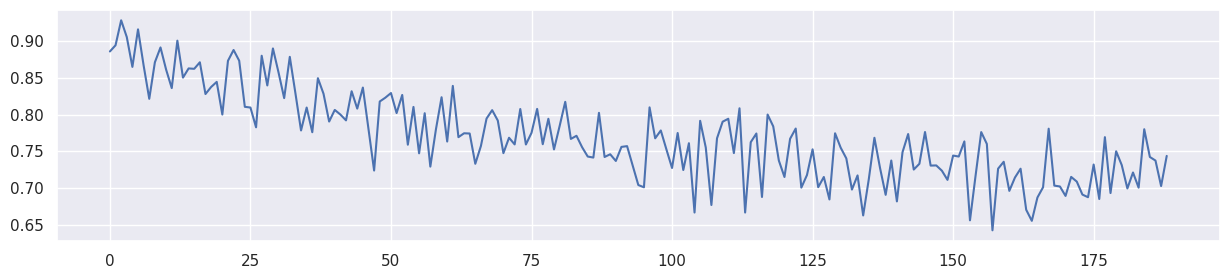

Mean F1 for all data: 0.7699571269153709
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 99.886414] [G loss: 0.665513]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 197.042358] [G loss: 0.576178]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 213.731094] [G loss: 0.514885]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 205.908340] [G loss: 0.475181]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 189.004288] [G loss: 0.438458]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 166.800385] [G loss: 0.401709]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 143.602219] [G loss: 0.367107]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 121.665749] [G loss: 0.334385]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 109.274399] [G loss: 0.303903]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 92.325531] [G loss: 0.279836]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 78.715942] [G loss: 0.259242]
[Lambda: 0.400000] [Epoch 2400/400

100%|██████████| 189/189 [00:00<00:00, 485.84it/s]


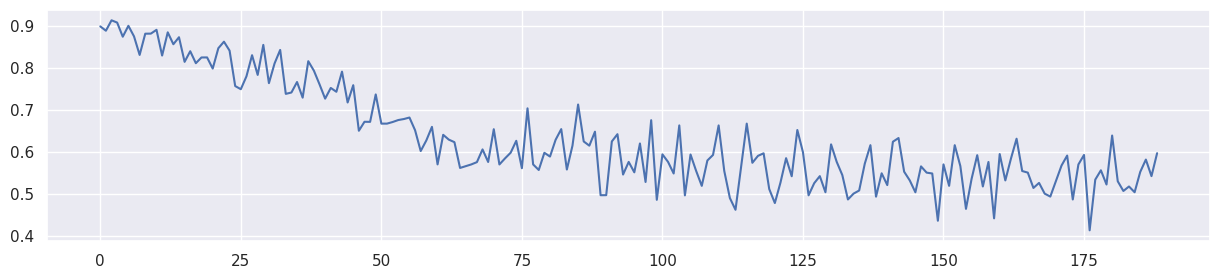

Mean F1 for all data: 0.6331894632164938
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 97.788910] [G loss: 0.666567]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 182.409668] [G loss: 0.579247]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 200.264328] [G loss: 0.516289]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 186.801193] [G loss: 0.477293]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 166.127426] [G loss: 0.440712]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 145.302277] [G loss: 0.401914]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 127.423004] [G loss: 0.365561]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 109.887291] [G loss: 0.332183]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 94.346069] [G loss: 0.300749]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 83.680840] [G loss: 0.274703]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 78.037819] [G loss: 0.256351]
[Lambda: 0.500000] [Epoch 2400/4000

100%|██████████| 189/189 [00:00<00:00, 492.32it/s]


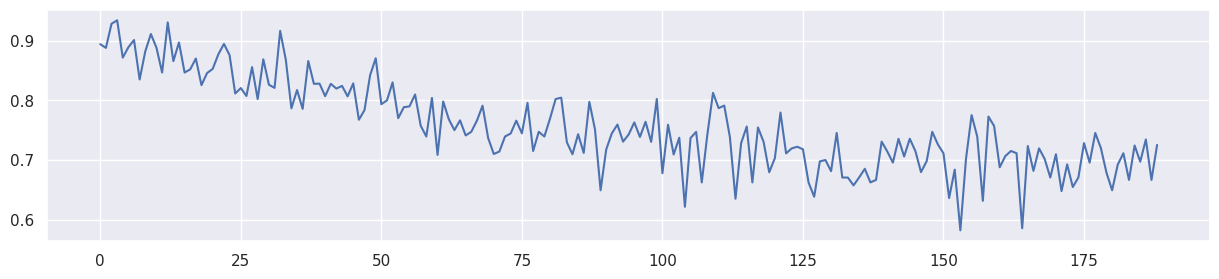

Mean F1 for all data: 0.7568396403825353
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: 95.719437] [G loss: 0.668006]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: 160.993851] [G loss: 0.591618]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: 182.298553] [G loss: 0.520565]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: 165.065598] [G loss: 0.480157]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: 144.012253] [G loss: 0.440675]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: 125.486458] [G loss: 0.400740]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: 107.397926] [G loss: 0.362003]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: 91.974678] [G loss: 0.324298]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: 83.003479] [G loss: 0.290222]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: 77.729340] [G loss: 0.265550]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: 74.165131] [G loss: 0.248363]
[Lambda: 0.600000] [Epoch 2400/4000]

100%|██████████| 189/189 [00:00<00:00, 487.21it/s]


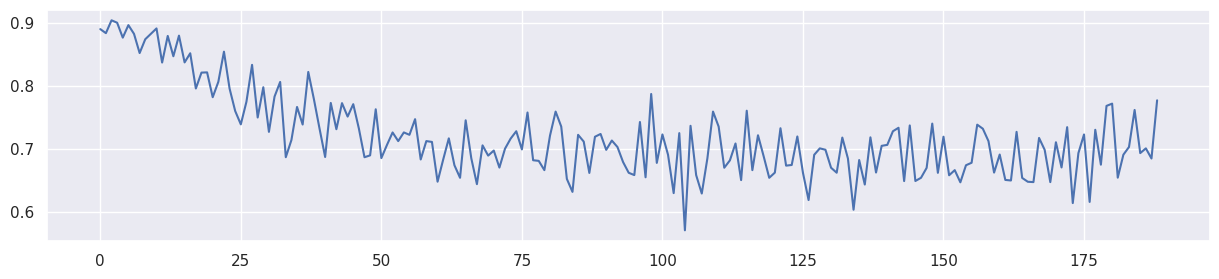

Mean F1 for all data: 0.7216854897379624
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: 93.876526] [G loss: 0.669395]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: 138.312439] [G loss: 0.607139]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: 165.487610] [G loss: 0.528706]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: 144.674301] [G loss: 0.484493]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: 125.560982] [G loss: 0.440764]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: 107.939095] [G loss: 0.396539]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: 93.815247] [G loss: 0.352251]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: 84.745514] [G loss: 0.311501]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: 79.183800] [G loss: 0.279007]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: 75.569450] [G loss: 0.256086]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: 73.202301] [G loss: 0.241990]
[Lambda: 0.700000] [Epoch 2400/4000] 

100%|██████████| 189/189 [00:00<00:00, 509.91it/s]


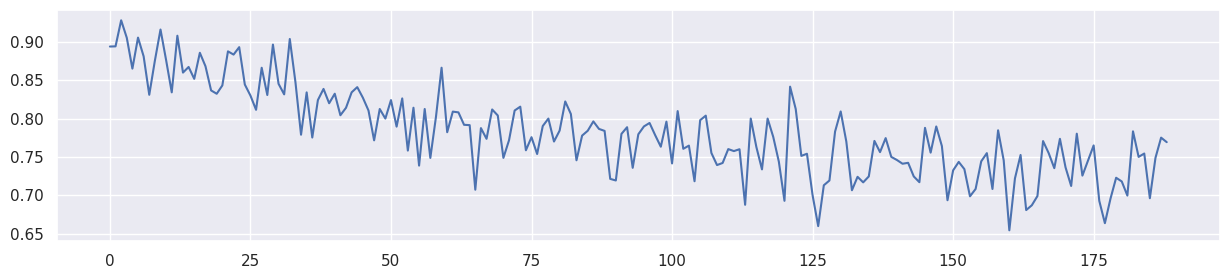

Mean F1 for all data: 0.782278294135506
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: 92.723511] [G loss: 0.670305]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: 89.146370] [G loss: 0.646817]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: 85.495941] [G loss: 0.616318]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: 81.624222] [G loss: 0.576955]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: 77.460754] [G loss: 0.526441]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: 73.326736] [G loss: 0.469271]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: 69.668373] [G loss: 0.416513]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: 66.685799] [G loss: 0.376129]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: 64.369682] [G loss: 0.350362]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: 62.601124] [G loss: 0.336253]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: 61.196770] [G loss: 0.329088]
[Lambda: 0.800000] [Epoch 2400/4000] [mi lo

100%|██████████| 189/189 [00:00<00:00, 510.41it/s]


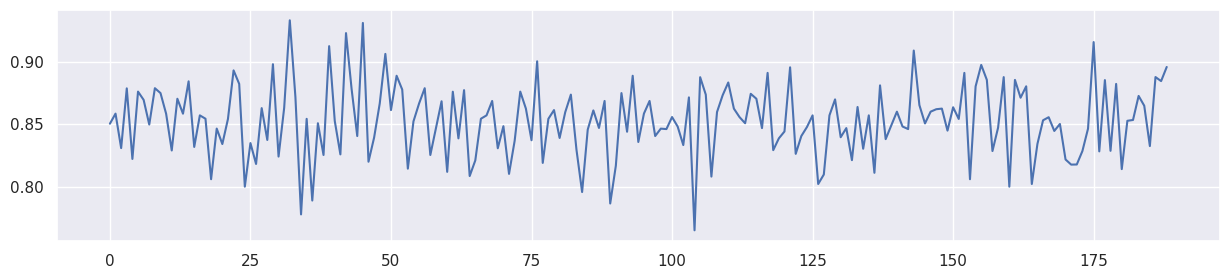

Mean F1 for all data: 0.8528047633954339
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 96.868950] [G loss: 0.687076]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: 70.132034] [G loss: 0.675432]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: 32.705696] [G loss: 0.643234]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: 31.037699] [G loss: 0.611520]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: 26.678391] [G loss: 0.543549]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: 42.336670] [G loss: 0.347814]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: 39.690559] [G loss: 0.289757]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: 36.586475] [G loss: 0.263708]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: 34.510918] [G loss: 0.249073]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: 33.200043] [G loss: 0.240401]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: 32.350662] [G loss: 0.234825]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: 31.751562] [G loss: 0.231274]
[Lambda: 0.900000] [Epoch 2400/4000] [mi l

100%|██████████| 189/189 [00:00<00:00, 509.34it/s]


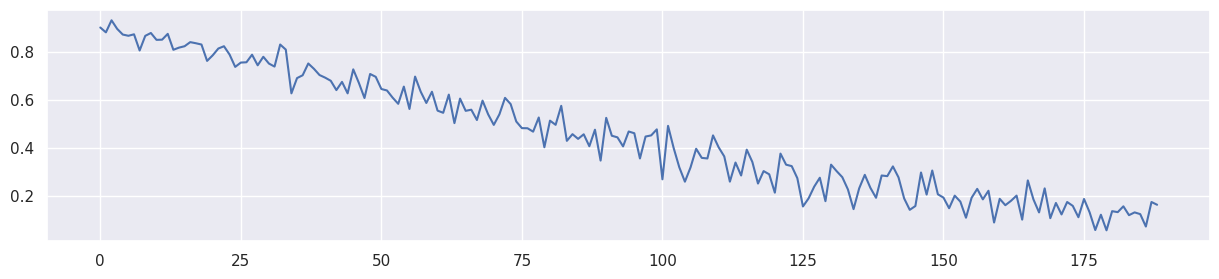

Mean F1 for all data: 0.4514556052932833


lambda   test_f1   init_f1   mean_f1   last_f1  MI(y^,z)
0  Feature 5  0.868571  0.889908  0.705877  0.623853  0.262262
1  Feature 6  0.875000  0.889908  0.299367  0.068966  0.230467
2  Feature 4  0.765714  0.871560  0.853043  0.904977  0.079596
0        0.0  0.875000  0.888889  0.716996  0.657407  0.261667
1        0.1  0.868571  0.883721  0.718557  0.651163  0.245552
2        0.2  0.868571  0.879630  0.721634  0.657407  0.245552
3        0.3  0.868571  0.895928  0.726968  0.663594  0.245552
4        0.4  0.875000  0.895928  0.731976  0.663594  0.243805
5        0.5  0.870056  0.900901  0.742371  0.663551  0.228285
6        0.6  0.868571  0.906667  0.752758  0.688073  0.230407
7        0.7  0.822222  0.877828  0.831724  0.842975  0.130351
8        0.8  0.551020  0.600000  0.537934  0.572816  0.118774
9        0.9  0.335135  0.310881  0.447334  0.526829  0.369255
0        0.0  0.866667  0.880734  0.777968  0.752137  0.293257
1        0.1  0.850575  0.898148  0.777833  0.755760  0.260484
2        0.2  0.876404  0.890909  0.792771  0.756757  0.256160
3        0.3  0.881356  0.885845  0.769957  0.743719  0.251513
4        0.4  0.878613  0.898148  0.633189  0.596273  0.236671
5        0.5  0.878613  0.894009  0.756840  0.725275  0.246974
6        0.6  0.873563  0.889908  0.721685  0.777202  0.217493
7        0.7  0.868571  0.894009  0.782278  0.769231  0.213551
8        0.8  0.786127  0.850467  0.852805  0.895928  0.100520
9        0.9  0.857143  0.901408  0.451456  0.163934  0.242422

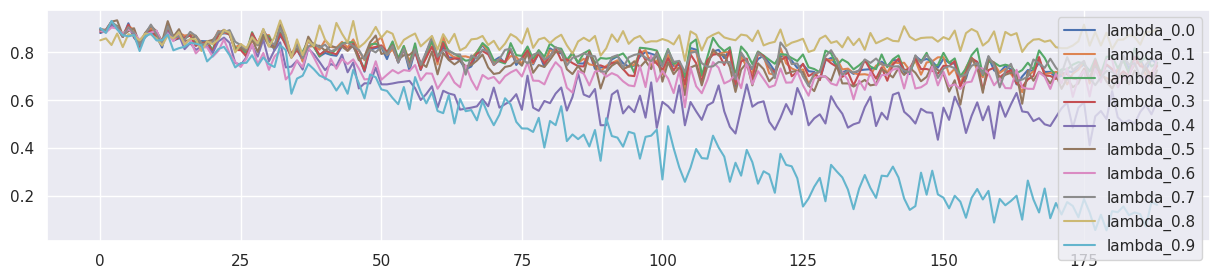

In [55]:
seed_everything()

train_result = []

avaible_range = 800

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    '''
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
    '''
    f1,mi,last_generator, last_adapter = train_model5(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.000153)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,last_adapter,2000)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result4_df = pd.DataFrame(result_table2)

pd.concat([result3_df, result2_df,result4_df])



## D(G(x,b)) 구조

<pre>
x0 ------>|                     |- x'0 --> |                        |
x1 ------>|  Generator G(xi,b)  |- x'1 --> |                        |
x2 ------>|  (Adaptive model)   |- x'2 --> | Discriminator (D(x,g)) | -> y^
x3 ------>|                     |- x'3 --> | predictive model       |
z0 ------>|                     |- z'0 --> |                        |
                     ^
                     |
                     b
</pre>

+ 사실 입력 $x_i$ 에서 어떤 feature가 시간에 따라 importance가 변하는지 알기 어렵다. trainset의 경우, bucket size가 크지 않을 수 있으며, 또한 I(z,b)가 분명하게 나타나지 않을 수도 있기 때문이다.
+ 따라서 상기와 같은 구조를 제안한다.
+ 실험3~4는 sensitive featrue z에 대해, G(z,b)으로 전처리 하였으나, 이번 구조는 모든 feature에 대하여 $G(x_i,b)$으로 전처리한다.
+ $I(x_i,b) > 0$ 인 feature는 G에 의해 전처리 될 것이고,$I(x_j,b) = 0$ 인 feature는 G에 의해 by-pass 되도록 학습될 것이다.

In [149]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):
   
    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""
        
        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        #self.fc3 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(2, 40))
            self.fc2.append(nn.Linear(40, 1))
            #self.fc3.append(nn.Linear(5, 1))

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1)))
            #h1 = F.relu(self.fc2[i](h0))
            #h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = self.fc2[i](h0)
            h2 = self.fc2[i](h0)
            pxy.append(h2)
            
        return torch.cat(pxy, dim=1)

In [57]:

def test_model6(model_,model2_, tX, ty, s1):
    model_.eval()
    model2_.eval()

    ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [58]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model6(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net()
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  MINE -> I(Z,B)의 측정
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model6(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator,adapter

In [159]:
def test_all_data6(generator,adapter,train_size):

    XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            xs = adapter(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(xs)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [161]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

#lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.1, 1.2, 1.3, 1.4] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model6(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data6(last_generator,last_adapter,2000)

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))
    #plt.show()
    result4_df = pd.DataFrame(result_table2)

    print(lambda_f2,result4_df)

pd.concat([result3_df, result2_df,result4_df])



KeyboardInterrupt: ignored

<pre>
x0 ------>|                     |- x'0 --> |                | - x'0 --> |                        |
x1 ------>|  Generator G(xi,b)  |- x'1 --> |                | - x'1 --> |                        |
x2 ------>|  (Adaptive model)   |- x'2 --> | MINE (I(x',y)) | - x'2 --> | Discriminator (D(x')   | -> y'
x3 ------>|                     |- x'3 --> | MI model       | - x'3 --> | predictive mode        |
z0 ------>|                     |- z'0 --> |                | - z'0 --> |                        |
                     ^
                     |
                     b
</pre>

In [ ]:
class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H+1, 1))
            #self.fc4.append(nn.Linear(2, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y))
            h1 = self.fc3[i](torch.cat((h0, x[:,-1].reshape(-1,1)), 1) )
            #h2 = self.fc3[i](torch.cat((h0, x[:,-1].reshape(-1,1)), 1) )
            h.append(h1)

        return torch.cat(h, dim=1)  

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model7(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(5)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  Forwards Adapter
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  I(x',y)의 MINE loss
        # -------------------------------
        
        s = np.random.choice(XS_train.shape[0],minibatch)
        x_sample = xs[s]
        y_sample = y_train[s].reshape(-1,1)
        y_shuffle = y_train[np.random.permutation(s)].reshape(-1,1)
        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = - ret1



        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha + mi_loss.mean() * lambda_a2 *5

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [a2: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, lambda_a2,epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model6(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator,adapter

In [ ]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

#lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lambda_f_set = [0.7]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

lambda_f_set2 = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    lambda_a2 = lambda_f2
        
    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model7(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= 0.000517)
        result_table[f'lambda_{lambda_f}'] = test_all_data6(last_generator,last_adapter,2000)

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))

    result4_df = pd.DataFrame(result_table2)

    print(result4_df)

